In [19]:
import pandas as pd
import numpy as np
from arch import arch_model
from scipy.stats import genpareto, chi2
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import warnings

In [20]:
def compute_log_returns(filepath, outlier_threshold=50):
    """
    로그 수익률을 계산하고 이상치를 처리
    outlier_threshold: 이상치로 간주할 수익률의 임계값 (%)
    """
    df = pd.read_csv(filepath)
    df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
    df = df.sort_values("Date")
    df["Price"] = df["Price"].astype(str).str.replace(",", "").astype(float)
    df["LogReturn"] = 100 * np.log(df["Price"] / df["Price"].shift(1))
    df = df.dropna(subset=["LogReturn"])
    
    # 이상치 처리: threshold를 초과하는 수익률을 전날 값으로 대체
    outlier_mask = np.abs(df["LogReturn"]) > outlier_threshold
    n_outliers = outlier_mask.sum()
    
    if n_outliers > 0:
        print(f"  발견된 이상치: {n_outliers}개")
        # 이상치 정보 출력
        outliers = df[outlier_mask][["Date", "Price", "LogReturn"]]
        for idx, row in outliers.iterrows():
            print(f"    {row['Date'].date()}: {row['LogReturn']:.2f}%")
        
        # 이상치를 전날 수익률로 대체
        for i in range(len(df)):
            if outlier_mask.iloc[i]:
                if i > 0:
                    # 전날 수익률로 대체
                    df.iloc[i, df.columns.get_loc("LogReturn")] = df.iloc[i-1]["LogReturn"]
                else:
                    # 첫날인 경우 0으로 대체
                    df.iloc[i, df.columns.get_loc("LogReturn")] = 0
    
    df = df.set_index("Date")
    
    train_df = df[(df.index >= '2015-01-01') & (df.index <= '2020-12-31')]
    test_df = df[(df.index >= '2021-01-01') & (df.index <= '2024-12-31')]
    
    return df[["LogReturn"]], train_df[["LogReturn"]], test_df[["LogReturn"]]

# 자산 파일 정의
asset_files = {
    'AAPL': 'Apple Stock Price History.csv',
    'Alphabet': 'Alphabet A Stock Price History.csv', 
    'MSFT': 'Microsoft Stock Price History.csv',
    'NVDA': 'NVIDIA Stock Price History.csv'
}

# 모든 수익률 데이터 수집
print("데이터 로딩 및 이상치 처리 중...")
all_returns = pd.DataFrame()

# test_df를 저장할 딕셔너리 생성
test_returns = {}

# 모든 데이터를 다시 로드하여 train과 test 분리
for name, path in asset_files.items():
    print(f"\n{name} 처리 중...")
    _, train_df, test_df = compute_log_returns(path)
    all_returns[name] = train_df['LogReturn']
    test_returns[name] = test_df['LogReturn']  # test 데이터도 저장

# 결측치 처리
all_returns = all_returns.fillna(method='ffill').fillna(method='bfill')
test_returns_df = pd.DataFrame(test_returns).fillna(method='ffill').fillna(method='bfill')

train_returns = all_returns

# 1. GJR-GARCH 모델 피팅
# ===================================================
gjr_garch_results = {}

for name in train_returns.columns:  # .items() 대신 .columns 사용
    returns = train_returns[name]
    
    # GJR-GARCH 모델 설정
    model = arch_model(returns, vol='GARCH', p=1, o=1, q=1, dist='t')
    res = model.fit(disp='off')
    print(res.summary())
    # 표준화된 잔차 계산
    std_resid = res.resid / res.conditional_volatility
    
    # 예측 - test_returns_df 사용
    forecasts = res.forecast(horizon=len(test_returns_df[name]), reindex=False)
    forecasted_sigma = np.sqrt(forecasts.variance.values.flatten())
    
    # 결과 저장
    gjr_garch_results[name] = {
        'std_resid': std_resid.dropna(),
        'forecasted_sigma': forecasted_sigma,
        'params': res.params,
        'model': res  # 모델 객체도 저장
    }
    
    print(f"GJR-GARCH(1,1)-t model fitted for {name}.")
    print(f"  Parameters: omega={res.params['omega']:.6f}, "
          f"alpha={res.params['alpha[1]']:.6f}, "
          f"gamma={res.params['gamma[1]']:.6f}, "
          f"beta={res.params['beta[1]']:.6f}, "
          f"nu={res.params['nu']:.2f}")

# 결과 확인
print("\n모델 피팅 완료!")
print(f"Train 기간: {train_returns.index[0].date()} ~ {train_returns.index[-1].date()}")
print(f"Test 기간: {test_returns_df.index[0].date()} ~ {test_returns_df.index[-1].date()}")

데이터 로딩 및 이상치 처리 중...

AAPL 처리 중...
  발견된 이상치: 2개
    2016-02-27: 138.66%
    2016-02-29: -138.91%

Alphabet 처리 중...
  발견된 이상치: 2개
    2016-02-27: 299.55%
    2016-02-29: -300.60%

MSFT 처리 중...

NVDA 처리 중...
  발견된 이상치: 2개
    2016-02-27: 369.08%
    2016-02-29: -370.35%
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                         AAPL   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -2784.05
Distribution:      Standardized Student's t   AIC:                           5580.10
Method:                  Maximum Likelihood   BIC:                           5612.02
                                              No. Observations:                 1511
Date:                      Sat, Jun 21 2025   Df Residuals:                     1510
Time:                              23:25:56   Df M


=== GJR-GARCH 변동성 플롯 생성 중 ===


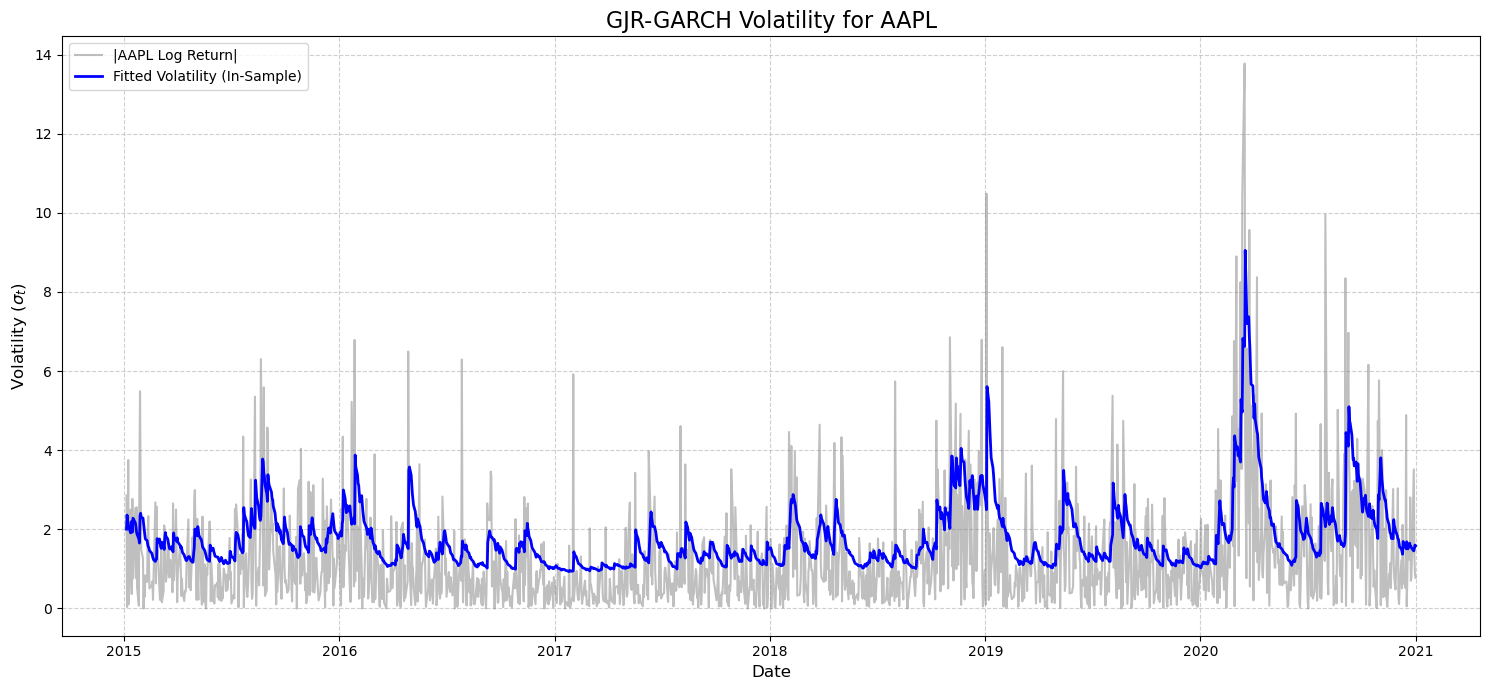

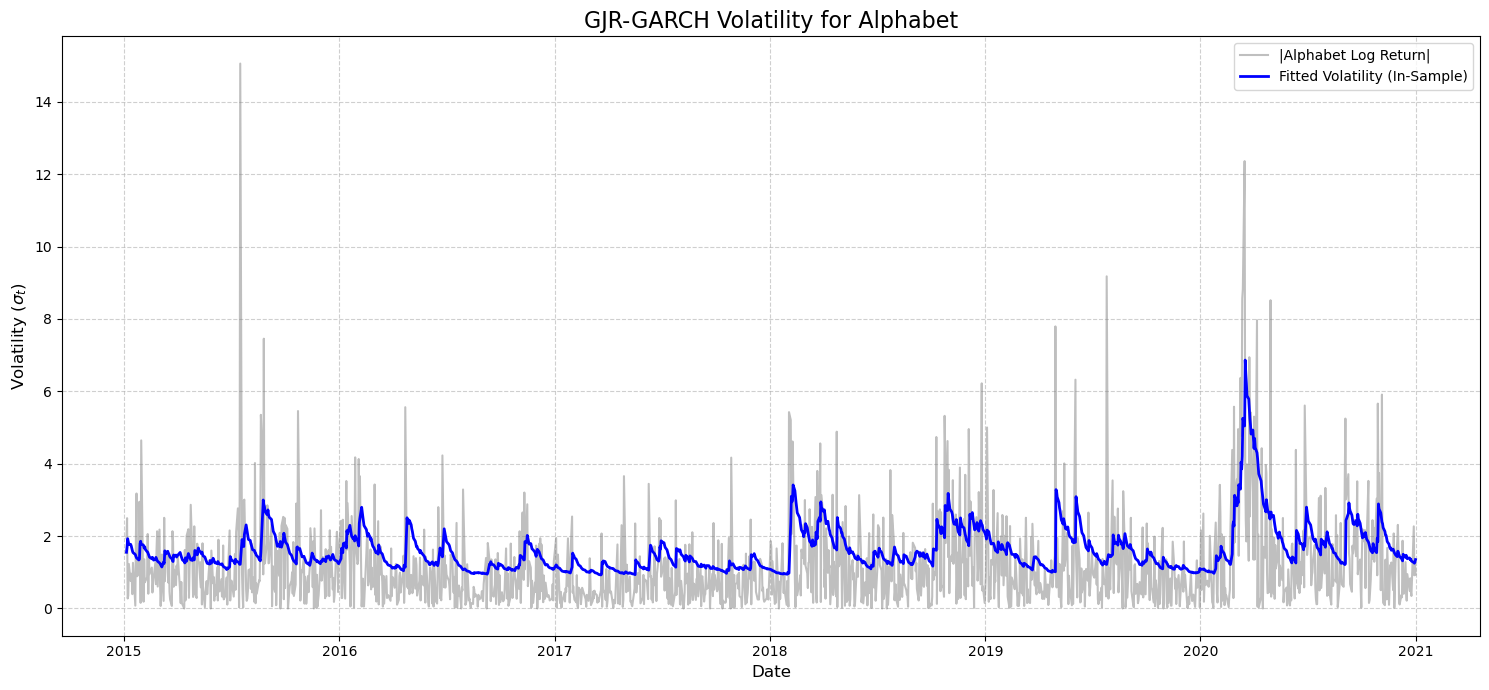

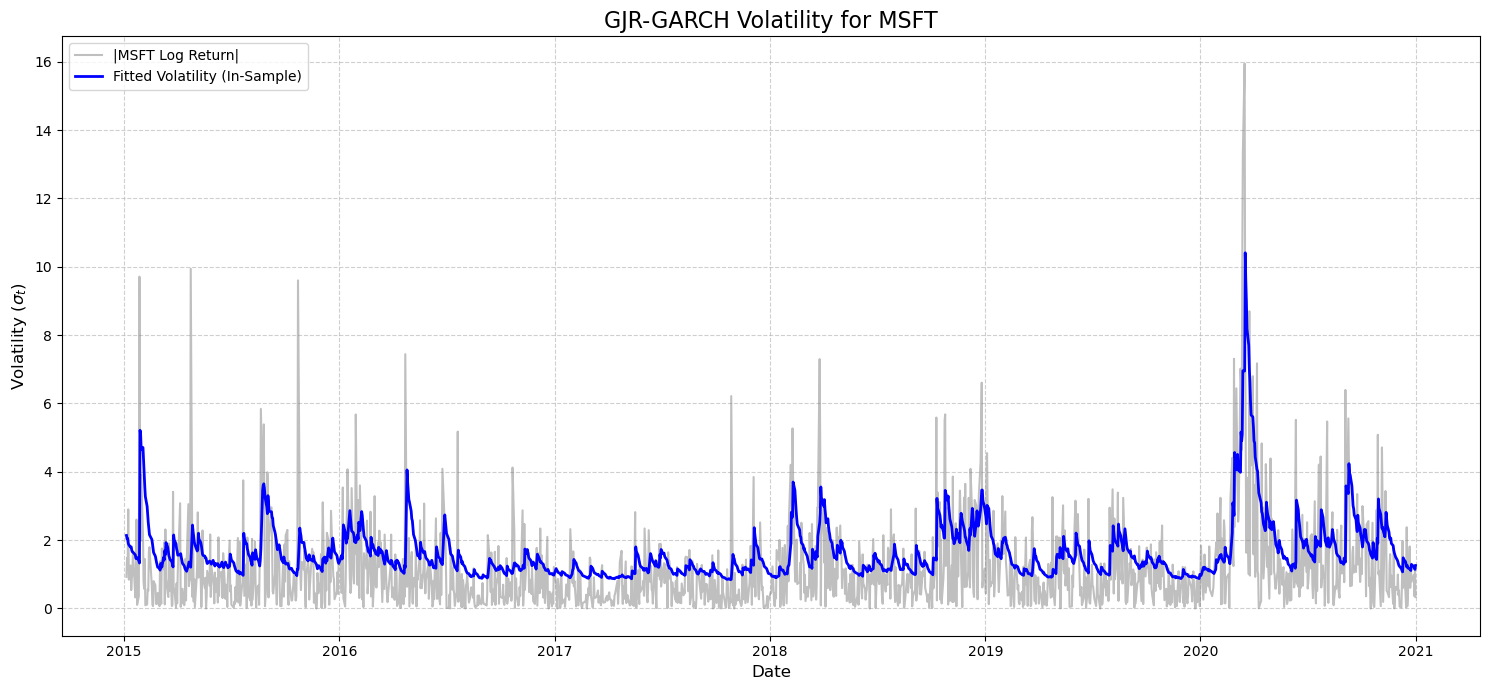

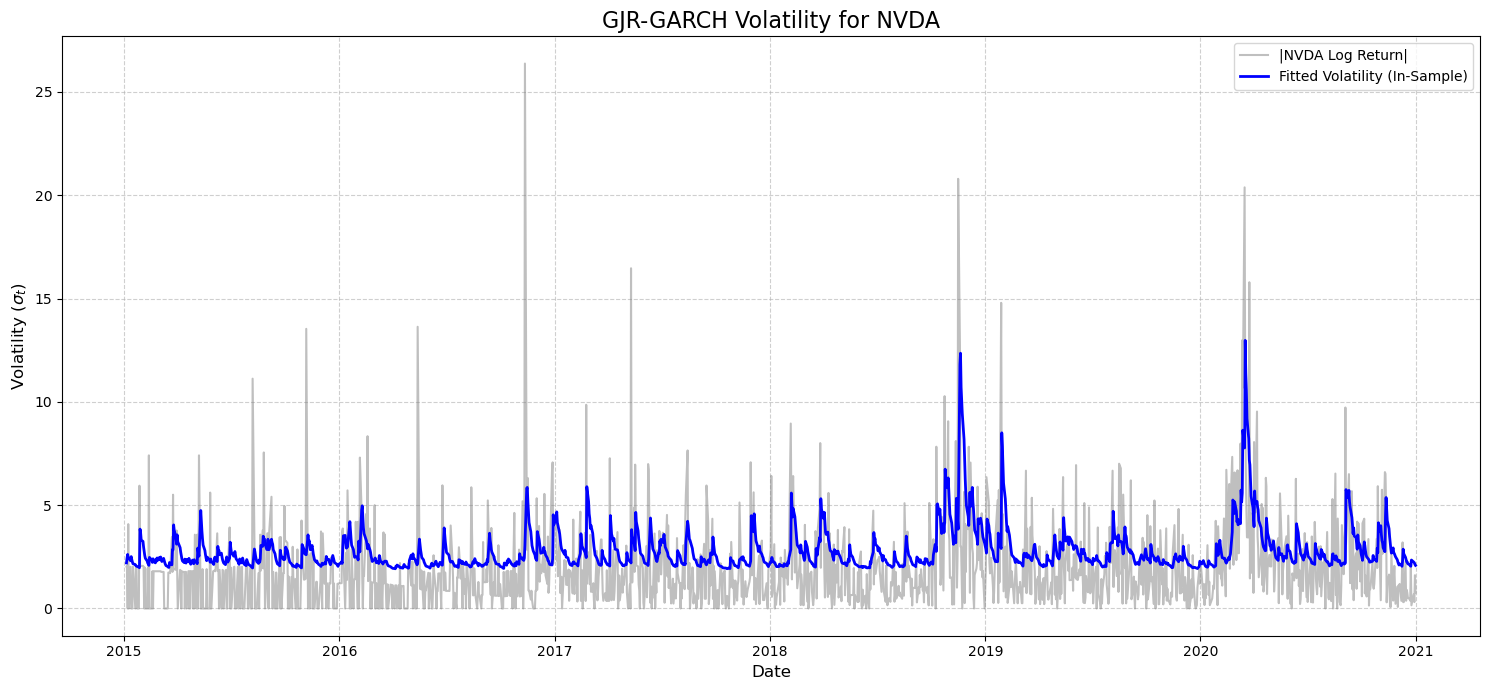

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arch import arch_model

# ===== GJR-GARCH 변동성 플롯 생성 =====
print("\n=== GJR-GARCH 변동성 플롯 생성 중 ===")

for name in gjr_garch_results.keys():
    model_result = gjr_garch_results[name]
    
    # 데이터 준비
    # In-sample (학습 기간) 조건부 변동성
    in_sample_vol = model_result['model'].conditional_volatility
    
    forecasted_vol = pd.Series(model_result['forecasted_sigma'], index=test_returns_df.index)
    
    # 시각화
    plt.figure(figsize=(15, 7))
    
    # 원본 수익률의 절대값 (변동성 군집 현상을 보기 위함)
    plt.plot(train_returns.index, np.abs(train_returns[name]), color='grey', alpha=0.5, label=f'|{name} Log Return|')
    
    # 적합된 변동성 (In-Sample)
    plt.plot(in_sample_vol.index, in_sample_vol, color='blue', lw=2, label='Fitted Volatility (In-Sample)')

    
    # 플롯 설정
    plt.title(f'GJR-GARCH Volatility for {name}', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Volatility ($\\sigma_t$)', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

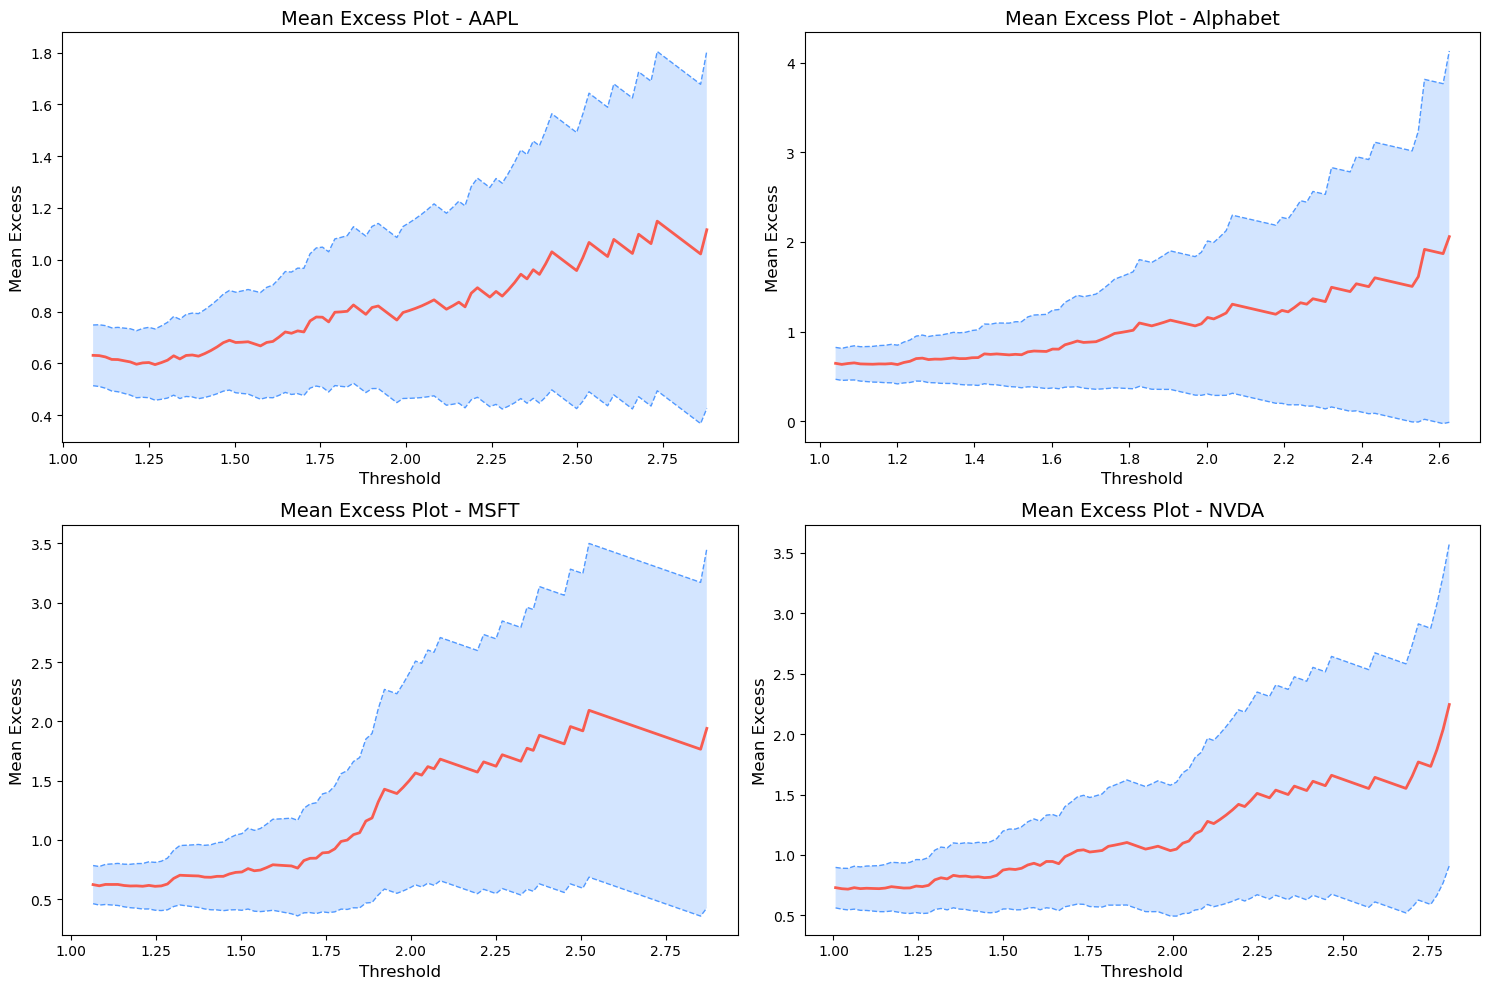

In [22]:
std_residuals_dict = {}
for name, results_dict in gjr_garch_results.items():
    std_residuals_dict[name] = results_dict['std_resid']

from pyextremes import plot_mean_residual_life
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for idx, (asset_name, residuals) in enumerate(std_residuals_dict.items()):
    ax = plot_mean_residual_life(residuals, ax=axes[idx])
    ax.set_title(f'Mean Excess Plot - {asset_name}', fontsize=14)
    ax.set_xlabel('Threshold', fontsize=12)
    ax.set_ylabel('Mean Excess', fontsize=12)

plt.tight_layout()
plt.show()

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde, genpareto
from statsmodels.distributions.empirical_distribution import ECDF
import warnings

class ParetoTailsEVT:
    def __init__(self, data, tail_fraction=0.1, method='kernel'):
        self.data = np.asarray(data).flatten()
        self.n = len(self.data)
        self.tail_fraction = tail_fraction
        self.method = method
        
        # Determine thresholds
        self.lower_threshold = np.quantile(self.data, tail_fraction)
        self.upper_threshold = np.quantile(self.data, 1 - tail_fraction)
        
        # Fit the model
        self._fit()
        
    def _fit(self):
        """Fit GPD to tails and kernel/empirical to interior"""
        
        # 1. Lower tail GPD fitting
        lower_tail_data = self.data[self.data < self.lower_threshold]
        lower_exceedances = self.lower_threshold - lower_tail_data
        
        if len(lower_exceedances) > 20:  # Need sufficient data
            try:
                self.lower_gpd = genpareto.fit(lower_exceedances, floc=0)
                self.n_lower = len(lower_exceedances)
            except:
                warnings.warn("Lower tail GPD fitting failed, using default parameters")
                self.lower_gpd = (0.1, 0, 1)  # Default: shape, loc, scale
                self.n_lower = len(lower_exceedances)
        else:
            self.lower_gpd = (0.1, 0, 1)
            self.n_lower = len(lower_exceedances)
            
        # 2. Upper tail GPD fitting  
        upper_tail_data = self.data[self.data > self.upper_threshold]
        upper_exceedances = upper_tail_data - self.upper_threshold
        
        if len(upper_exceedances) > 20:
            try:
                self.upper_gpd = genpareto.fit(upper_exceedances, floc=0)
                self.n_upper = len(upper_exceedances)
            except:
                warnings.warn("Upper tail GPD fitting failed, using default parameters")
                self.upper_gpd = (0.1, 0, 1)
                self.n_upper = len(upper_exceedances)
        else:
            self.upper_gpd = (0.1, 0, 1)
            self.n_upper = len(upper_exceedances)
            
        # 3. Interior fitting
        interior_data = self.data[(self.data >= self.lower_threshold) & 
                                 (self.data <= self.upper_threshold)]
        
        if self.method == 'kernel' and len(interior_data) > 1:
            try:
                self.interior_kde = gaussian_kde(interior_data, bw_method='scott')
            except:
                self.interior_kde = None
        else:
            self.interior_kde = None
        
        # Always create empirical CDF for interior
        self.interior_ecdf = ECDF(interior_data)
        
        # Store probabilities at thresholds
        self.p_lower = self.tail_fraction
        self.p_upper = 1 - self.tail_fraction
        
    def cdf(self, x):
        """
        Semi-parametric CDF:
        - GPD extrapolation for lower tail (x < lower_threshold)
        - Empirical/Kernel for interior
        - GPD extrapolation for upper tail (x > upper_threshold)
        """
        x = np.asarray(x)
        scalar_input = x.ndim == 0
        x = np.atleast_1d(x)
        
        result = np.zeros_like(x, dtype=float)
        
        # Process each point
        for i, xi in enumerate(x):
            if xi < self.lower_threshold:
                # Lower tail: use GPD survival function
                exceedance = self.lower_threshold - xi
                if exceedance > 0 and self.n_lower > 0:
                    # GPD survival probability
                    tail_prob = genpareto.sf(exceedance, *self.lower_gpd)
                    # Scale by the fraction of data in lower tail
                    result[i] = self.p_lower * tail_prob
                else:
                    result[i] = 0.0
                    
            elif xi > self.upper_threshold:
                # Upper tail: use GPD CDF
                exceedance = xi - self.upper_threshold
                if exceedance >= 0 and self.n_upper > 0:
                    # GPD cumulative probability
                    tail_prob = genpareto.cdf(exceedance, *self.upper_gpd)
                    # Add to upper threshold probability
                    result[i] = self.p_upper + (1 - self.p_upper) * tail_prob
                else:
                    result[i] = 1.0
                    
            else:
                # Interior: use empirical CDF
                interior_prob = self.interior_ecdf(xi)
                # Scale to fit between tail probabilities
                result[i] = self.p_lower + (self.p_upper - self.p_lower) * interior_prob
        
        # Ensure valid probabilities
        result = np.clip(result, 0, 1)
        
        return result[0] if scalar_input else result
    
    def icdf(self, p):
        """Inverse CDF (quantile function)"""
        p = np.asarray(p)
        scalar_input = p.ndim == 0
        p = np.atleast_1d(p)
        
        result = np.zeros_like(p, dtype=float)
        
        for i, pi in enumerate(p):
            if pi <= 0:
                result[i] = -np.inf
            elif pi >= 1:
                result[i] = np.inf
            elif pi < self.p_lower:
                # Lower tail: inverse GPD
                if self.n_lower > 0:
                    # Convert to tail probability
                    tail_prob = pi / self.p_lower
                    # Get exceedance from GPD
                    exceedance = genpareto.isf(tail_prob, *self.lower_gpd)
                    result[i] = self.lower_threshold - exceedance
                else:
                    result[i] = self.lower_threshold
                    
            elif pi > self.p_upper:
                # Upper tail: inverse GPD
                if self.n_upper > 0:
                    # Convert to tail probability
                    tail_prob = (pi - self.p_upper) / (1 - self.p_upper)
                    # Get exceedance from GPD
                    exceedance = genpareto.ppf(tail_prob, *self.upper_gpd)
                    result[i] = self.upper_threshold + exceedance
                else:
                    result[i] = self.upper_threshold
                    
            else:
                # Interior: use empirical quantile
                interior_prob = (pi - self.p_lower) / (self.p_upper - self.p_lower)
                
                # Get quantile from interior data
                interior_data = self.data[(self.data >= self.lower_threshold) & 
                                        (self.data <= self.upper_threshold)]
                if len(interior_data) > 0:
                    result[i] = np.quantile(interior_data, interior_prob)
                else:
                    result[i] = (self.lower_threshold + self.upper_threshold) / 2
        
        return result[0] if scalar_input else result



Figure saved to: thesis_evt_cdfs_gjrgarch.png


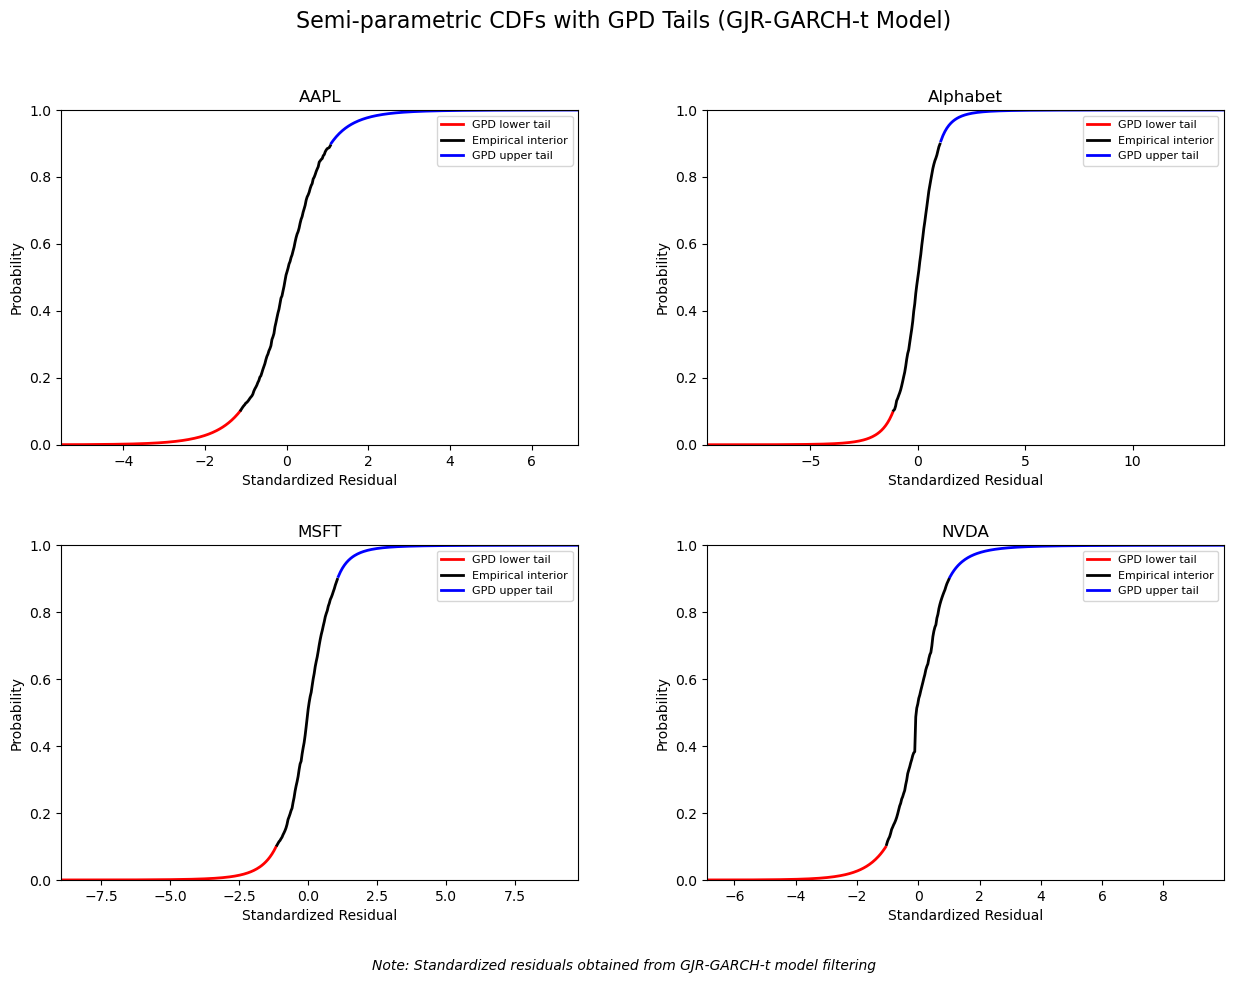


EVT Model Summary (GJR-GARCH-filtered residuals)

AAPL:
  Lower GPD - Shape (ξ): 0.0513, Scale (σ): 0.6511
  Upper GPD - Shape (ξ): 0.1156, Scale (σ): 0.5574
  Thresholds - Lower: -1.1453, Upper: 1.0872
  Uniform data - Min: 0.0011, Max: 0.9998, Mean: 0.5004

Alphabet:
  Lower GPD - Shape (ξ): 0.1687, Scale (σ): 0.6019
  Upper GPD - Shape (ξ): 0.2288, Scale (σ): 0.4816
  Thresholds - Lower: -1.1425, Upper: 1.0415
  Uniform data - Min: 0.0002, Max: 1.0000, Mean: 0.5004

MSFT:
  Lower GPD - Shape (ξ): 0.1636, Scale (σ): 0.5829
  Upper GPD - Shape (ξ): 0.2506, Scale (σ): 0.4548
  Thresholds - Lower: -1.1580, Upper: 1.0658
  Uniform data - Min: 0.0002, Max: 0.9998, Mean: 0.5003

NVDA:
  Lower GPD - Shape (ξ): 0.0468, Scale (σ): 0.6931
  Upper GPD - Shape (ξ): 0.2356, Scale (σ): 0.5508
  Thresholds - Lower: -1.0524, Upper: 1.0063
  Uniform data - Min: 0.0004, Max: 0.9998, Mean: 0.5004


In [24]:
from matplotlib.gridspec import GridSpec

def plot_all_evt_cdfs(std_residuals_dict, tail_fraction=0.1, n_points=200, 
                      save_path='evt_cdfs_egarch.png', figsize=(15, 10)):

    
    # Number of stocks
    n_stocks = len(std_residuals_dict)
    
    # Create subplot layout (2x2 for 4 stocks)
    n_rows = 2
    n_cols = 2
    
    # Create figure
    fig = plt.figure(figsize=figsize)
    fig.suptitle('Semi-parametric CDFs with GPD Tails (GJR-GARCH-t Model)', 
                 fontsize=16)
    
    # Initialize storage
    evt_models = {}
    uniform_data_dict = {}
    
    # Create grid for subplots
    gs = GridSpec(n_rows, n_cols, figure=fig, hspace=0.3, wspace=0.25)
    
    # Process each stock
    for idx, (stock_name, residuals) in enumerate(std_residuals_dict.items()):
        # Create subplot
        ax = fig.add_subplot(gs[idx // n_cols, idx % n_cols])
        
        # Handle input data
        data = np.array(residuals)
        if data.ndim > 1:
            data = data[:, 0]
        
        # Create ParetoTails object
        tail_obj = ParetoTailsEVT(data, tail_fraction=tail_fraction, method='kernel')
        evt_models[stock_name] = tail_obj
        
        # Transform to uniform
        uniform_data = tail_obj.cdf(data)
        uniform_data_dict[stock_name] = uniform_data
        
        # Calculate plotting range
        data_min = np.min(data)
        data_max = np.max(data)
        data_range = data_max - data_min
        
        # Create x values for plotting
        x_plot = np.linspace(data_min - 0.2 * data_range, 
                            data_max + 0.2 * data_range, 
                            n_points * 3)
        
        # Calculate CDF values
        y_plot = tail_obj.cdf(x_plot)
        
        # Identify regions
        lower_mask = x_plot < tail_obj.lower_threshold
        upper_mask = x_plot > tail_obj.upper_threshold
        interior_mask = ~lower_mask & ~upper_mask
        
        # Plot each region
        if np.any(lower_mask):
            ax.plot(x_plot[lower_mask], y_plot[lower_mask], 'red', 
                   linewidth=2, label='GPD lower tail')
        
        if np.any(interior_mask):
            ax.plot(x_plot[interior_mask], y_plot[interior_mask], 'black', 
                   linewidth=2, label='Empirical interior')
        
        if np.any(upper_mask):
            ax.plot(x_plot[upper_mask], y_plot[upper_mask], 'blue', 
                   linewidth=2, label='GPD upper tail')
        
        # Formatting
        ax.set_xlabel('Standardized Residual')
        ax.set_ylabel('Probability')
        ax.set_title(f'{stock_name}')
        ax.set_xlim(data_min - 0.1 * data_range, data_max + 0.1 * data_range)
        ax.set_ylim(0, 1)
        
        # Add legend to each subplot
        ax.legend(loc='best', fontsize=8)
    
    # Add common note about EGARCH model
    fig.text(0.5, 0.02, 
             'Note: Standardized residuals obtained from GJR-GARCH-t model filtering', 
             ha='center', fontsize=10, style='italic')
    
    # Save figure
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\nFigure saved to: {save_path}")
    
    # Show figure
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("EVT Model Summary (GJR-GARCH-filtered residuals)")
    print("="*60)
    for stock_name, tail_obj in evt_models.items():
        print(f"\n{stock_name}:")
        print(f"  Lower GPD - Shape (ξ): {tail_obj.lower_gpd[0]:.4f}, Scale (σ): {tail_obj.lower_gpd[2]:.4f}")
        print(f"  Upper GPD - Shape (ξ): {tail_obj.upper_gpd[0]:.4f}, Scale (σ): {tail_obj.upper_gpd[2]:.4f}")
        print(f"  Thresholds - Lower: {tail_obj.lower_threshold:.4f}, Upper: {tail_obj.upper_threshold:.4f}")
        print(f"  Uniform data - Min: {uniform_data_dict[stock_name].min():.4f}, "
              f"Max: {uniform_data_dict[stock_name].max():.4f}, "
              f"Mean: {uniform_data_dict[stock_name].mean():.4f}")
    
    return evt_models, uniform_data_dict


evt_models, uniform_data_dict = plot_all_evt_cdfs(
     std_residuals_dict, 
     tail_fraction=0.1,
     save_path='thesis_evt_cdfs_gjrgarch.png'
 )

In [25]:
def fast_gpd_pvalue(exceedances, gpd_params, n_sim=500):
    """
    Faster p-value calculation using parametric bootstrap
    """
    n = len(exceedances)
    shape, loc, scale = gpd_params
    
    # Observed statistics
    exceedances_sorted = np.sort(exceedances)
    empirical_cdf = np.arange(1, n + 1) / n
    theoretical_cdf = genpareto.cdf(exceedances_sorted, shape, loc, scale)
    
    w2_obs = np.sum((theoretical_cdf - empirical_cdf)**2) + 1/(12*n)
    
    theoretical_cdf_safe = np.clip(theoretical_cdf, 1e-10, 1-1e-10)
    ad_terms = (2*np.arange(1, n+1) - 1) * (
        np.log(theoretical_cdf_safe) + 
        np.log(1 - theoretical_cdf_safe[::-1])
    )
    a2_obs = -n - np.sum(ad_terms) / n
    
    # Bootstrap
    w2_greater = 0
    a2_greater = 0
    
    for _ in range(n_sim):
        # Generate uniform random values
        u = np.sort(np.random.uniform(0, 1, n))
        
        # W2
        w2_boot = np.sum((u - empirical_cdf)**2) + 1/(12*n)
        if w2_boot >= w2_obs:
            w2_greater += 1
        
        # A2
        u_safe = np.clip(u, 1e-10, 1-1e-10)
        ad_terms_boot = (2*np.arange(1, n+1) - 1) * (
            np.log(u_safe) + np.log(1 - u_safe[::-1])
        )
        a2_boot = -n - np.sum(ad_terms_boot) / n
        if a2_boot >= a2_obs:
            a2_greater += 1
    
    return {
        'W2': w2_obs,
        'W2_pvalue': w2_greater / n_sim,
        'A2': a2_obs,
        'A2_pvalue': a2_greater / n_sim
    }

# 기존 evt_models가 있다고 가정하고 실행
if 'evt_models' in locals():
    for stock_name, evt_model in evt_models.items():
        print(f"\n{stock_name} GJR-GARCHt GPD Goodness-of-Fit Tests:")
        print("=" * 50)
        
        # Lower tail
        lower_exceedances = evt_model.lower_threshold - evt_model.data[evt_model.data < evt_model.lower_threshold]
        if len(lower_exceedances) > 20:
            print(f"\nLower tail (n={len(lower_exceedances)}):")
            lower_results = fast_gpd_pvalue(lower_exceedances, evt_model.lower_gpd, n_sim=500)
            
            print(f"  W² = {lower_results['W2']:.4f}, p-value = {lower_results['W2_pvalue']:.4f}")
            print(f"  A² = {lower_results['A2']:.4f}, p-value = {lower_results['A2_pvalue']:.4f}")
            
            # 해석
            if lower_results['W2_pvalue'] > 0.05:
                print("  → W² test: Good fit ✓")
            else:
                print("  → W² test: Poor fit ✗")
                
            if lower_results['A2_pvalue'] > 0.05:
                print("  → A² test: Good fit ✓")
            else:
                print("  → A² test: Poor fit ✗")
        
        # Upper tail
        upper_exceedances = evt_model.data[evt_model.data > evt_model.upper_threshold] - evt_model.upper_threshold
        if len(upper_exceedances) > 20:
            print(f"\nUpper tail (n={len(upper_exceedances)}):")
            upper_results = fast_gpd_pvalue(upper_exceedances, evt_model.upper_gpd, n_sim=500)
            
            print(f"  W² = {upper_results['W2']:.4f}, p-value = {upper_results['W2_pvalue']:.4f}")
            print(f"  A² = {upper_results['A2']:.4f}, p-value = {upper_results['A2_pvalue']:.4f}")
            
            # 해석
            if upper_results['W2_pvalue'] > 0.05:
                print("  → W² test: Good fit ✓")
            else:
                print("  → W² test: Poor fit ✗")
                
            if upper_results['A2_pvalue'] > 0.05:
                print("  → A² test: Good fit ✓")
            else:
                print("  → A² test: Poor fit ✗")


AAPL GJR-GARCHt GPD Goodness-of-Fit Tests:

Lower tail (n=151):
  W² = 0.0883, p-value = 0.6440
  A² = 0.4840, p-value = 0.7800
  → W² test: Good fit ✓
  → A² test: Good fit ✓

Upper tail (n=151):
  W² = 0.1220, p-value = 0.4580
  A² = 0.8269, p-value = 0.4100
  → W² test: Good fit ✓
  → A² test: Good fit ✓

Alphabet GJR-GARCHt GPD Goodness-of-Fit Tests:

Lower tail (n=151):
  W² = 0.0361, p-value = 0.9660
  A² = 0.2741, p-value = 0.9660
  → W² test: Good fit ✓
  → A² test: Good fit ✓

Upper tail (n=151):
  W² = 0.1271, p-value = 0.4460
  A² = 0.9630, p-value = 0.3780
  → W² test: Good fit ✓
  → A² test: Good fit ✓

MSFT GJR-GARCHt GPD Goodness-of-Fit Tests:

Lower tail (n=151):
  W² = 0.0512, p-value = 0.8660
  A² = 0.3187, p-value = 0.9140
  → W² test: Good fit ✓
  → A² test: Good fit ✓

Upper tail (n=151):
  W² = 0.2308, p-value = 0.2240
  A² = 1.5453, p-value = 0.1560
  → W² test: Good fit ✓
  → A² test: Good fit ✓

NVDA GJR-GARCHt GPD Goodness-of-Fit Tests:

Lower tail (n=151):
 


=== Analyzing AAPL ===


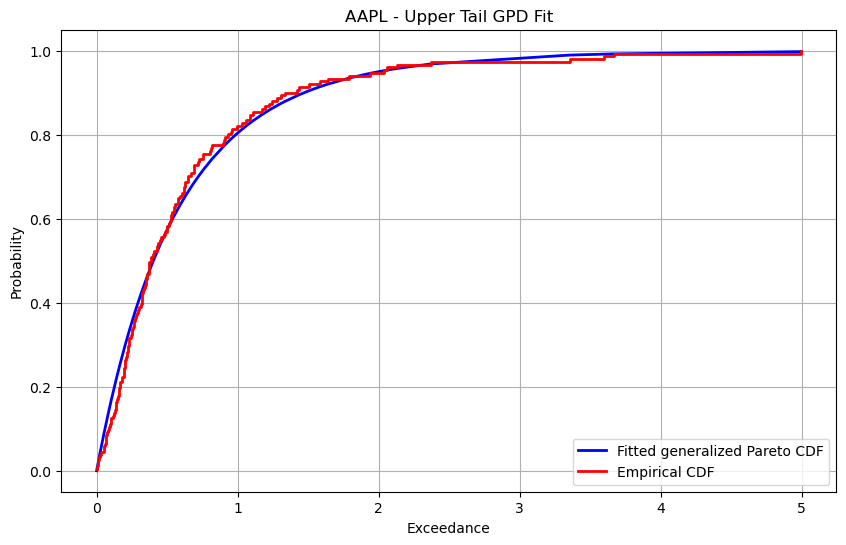

Threshold: 1.0872
Number of exceedances: 151
GPD Parameters - Shape: 0.1156, Scale: 0.5574

=== Analyzing Alphabet ===


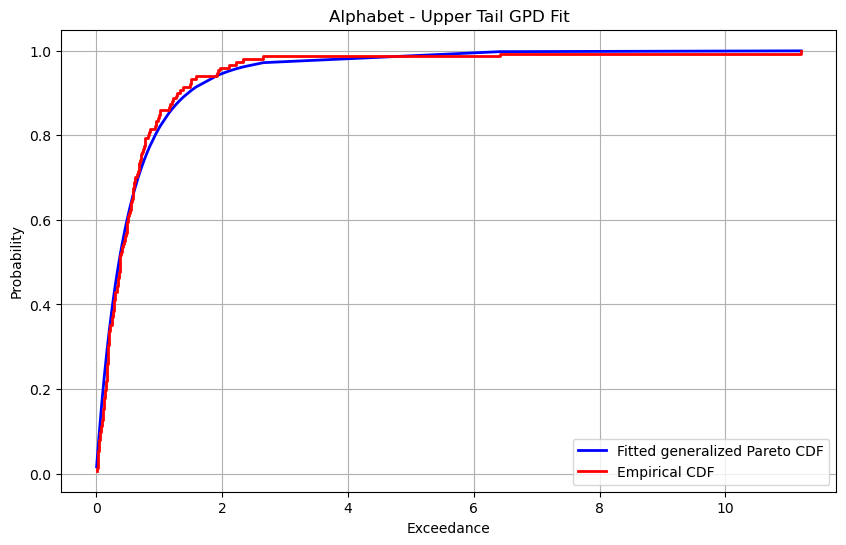

Threshold: 1.0415
Number of exceedances: 151
GPD Parameters - Shape: 0.2288, Scale: 0.4816

=== Analyzing MSFT ===


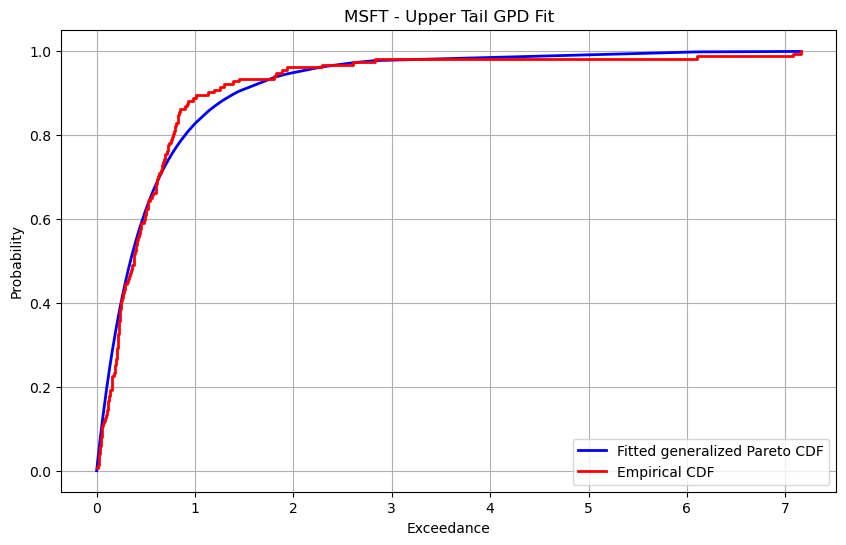

Threshold: 1.0658
Number of exceedances: 151
GPD Parameters - Shape: 0.2506, Scale: 0.4548

=== Analyzing NVDA ===


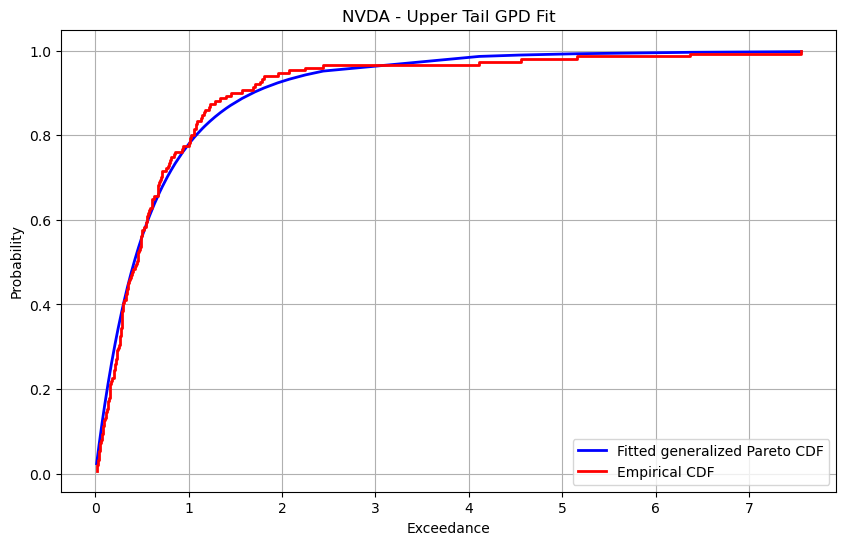

Threshold: 1.0063
Number of exceedances: 151
GPD Parameters - Shape: 0.2356, Scale: 0.5508


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import genpareto
import pandas as pd

class GPDFitter:
    """
    Generalized Pareto Distribution fitting for tail analysis
    """
    def __init__(self, data, threshold_quantile=0.9):
        self.data = np.array(data)
        self.threshold_quantile = threshold_quantile
        self.threshold = np.quantile(self.data, threshold_quantile)
        
        # Get exceedances (values above threshold)
        self.exceedances = self.data[self.data > self.threshold] - self.threshold
        self.exceedances = np.sort(self.exceedances)
        
        # Fit GPD to exceedances
        if len(self.exceedances) > 0:
            self.gpd_params = genpareto.fit(self.exceedances, floc=0)
            self.shape, self.loc, self.scale = self.gpd_params
        else:
            self.gpd_params = (0, 0, 1)
            self.shape, self.loc, self.scale = self.gpd_params
    
    def boundary(self):
        """
        Get boundary probabilities and quantiles
        Returns P (probabilities) and Q (quantiles) at boundaries
        """
        # P[0] = probability of exceedance (1 - threshold_quantile)
        # P[1] = probability mass in upper tail
        # Q[0] = lower boundary (threshold)
        # Q[1] = upper boundary (max value)
        
        P = np.array([1 - self.threshold_quantile, 1 - self.threshold_quantile])
        Q = np.array([self.threshold, np.max(self.data)])
        
        return P, Q
    
    def fitted_cdf(self, x):
        """Fitted GPD CDF for exceedances"""
        return genpareto.cdf(x, self.shape, self.loc, self.scale)
    
    def empirical_cdf(self, x):
        """Empirical CDF for exceedances"""
        F = np.searchsorted(self.exceedances, x, side='right') / len(self.exceedances)
        return F

def plot_gpd_fit(residuals, index=0, threshold_quantile=0.9, title=None):
    
    # Handle input data
    residuals = np.array(residuals)
    if residuals.ndim == 1:
        data = residuals
    else:
        data = residuals[:, index]
    
    # Create GPD fitter
    gpd_fitter = GPDFitter(data, threshold_quantile)
    
    # Get boundary information
    P, Q = gpd_fitter.boundary()
    
    # Get sorted exceedances
    y = gpd_fitter.exceedances
    
    if len(y) == 0:
        print("No exceedances found. Try lowering the threshold.")
        return None
    
    # Create probability points for fitted GPD
    fitted_probs = gpd_fitter.fitted_cdf(y)
    
    # Empirical CDF using step function approach
    F_emp = np.arange(1, len(y) + 1) / len(y)
    
    # Create plot
    plt.figure(figsize=(10, 6))
    
    # Plot fitted GPD CDF
    plt.plot(y, fitted_probs, 'b-', linewidth=2, label='Fitted generalized Pareto CDF')
    
    # Plot empirical CDF as step function
    plt.step(y, F_emp, 'r-', linewidth=2, where='post', label='Empirical CDF')
    
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.xlabel('Exceedance')
    plt.ylabel('Probability')
    plt.title(title if title else 'Upper Tail of Standardized Residuals')
    plt.show()
    
    # Print fitting statistics
    print(f"Threshold: {gpd_fitter.threshold:.4f}")
    print(f"Number of exceedances: {len(y)}")
    print(f"GPD Parameters - Shape: {gpd_fitter.shape:.4f}, Scale: {gpd_fitter.scale:.4f}")
    
    return gpd_fitter

def analyze_all_stocks_gpd(std_residuals_dict, threshold_quantile=0.9):
    """
    Analyze GPD fit for all stocks in the dictionary
    
    Parameters:
    -----------
    std_residuals_dict : dict
        Dictionary with stock names as keys and residual arrays as values
    threshold_quantile : float
        Quantile threshold for exceedances
    """
    gpd_results = {}
    
    # Convert dictionary to DataFrame for easier handling
    residuals_df = pd.DataFrame(std_residuals_dict)
    residuals = residuals_df.values
    
    for i, stock_name in enumerate(std_residuals_dict.keys()):
        print(f"\n=== Analyzing {stock_name} ===")
        gpd_fitter = plot_gpd_fit(residuals, index=i, threshold_quantile=threshold_quantile,
                                title=f'{stock_name} - Upper Tail GPD Fit')
        gpd_results[stock_name] = gpd_fitter
    
    return gpd_results

# Alternative function for single stock analysis
def analyze_single_stock_gpd(stock_data, stock_name, threshold_quantile=0.9):
    """
    Analyze GPD fit for a single stock
    
    Parameters:
    -----------
    stock_data : array-like
        Residual data for single stock
    stock_name : str
        Name of the stock
    threshold_quantile : float
        Quantile threshold for exceedances
    """
    print(f"\n=== Analyzing {stock_name} ===")
    gpd_fitter = plot_gpd_fit(stock_data, index=0, threshold_quantile=threshold_quantile,
                            title=f'{stock_name} - Upper Tail GPD Fit')
    return gpd_fitter

gpd_results = analyze_all_stocks_gpd(std_residuals_dict, threshold_quantile=0.9)

GJR-GARCHt-EVT-Copula
** Tree:  1
1,2  --->  Gumbel180 : parameters =  1.9115576738305442
0,2  --->  Gumbel180 : parameters =  1.6517675049969491
2,3  --->  Gumbel180 : parameters =  1.5857485324212695
** Tree:  2
1,0|2  --->  Frank : parameters =  1.9447987682522447
0,3|2  --->  Frank : parameters =  1.81778531657341
** Tree:  3
1,3|0,2  --->  Frank : parameters =  0.8474182166926588


<Figure size 1200x800 with 0 Axes>

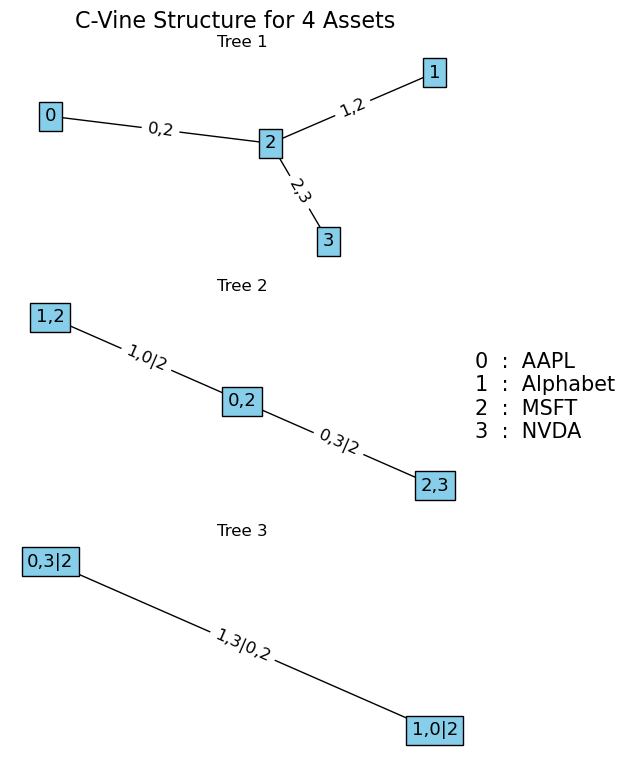

In [27]:
from vinecopulas.marginals import *
from vinecopulas.bivariate import *
from vinecopulas.vinecopula import *
uniform_evt = pd.DataFrame(uniform_data_dict)

# vinecopulas에서 사용할 numpy 배열로 변환
u_data = uniform_evt.values
u_data = uniform_evt.values
cops = list(range(1, 13)) 
print('GJR-GARCHt-EVT-Copula')
M, P, C = fit_vinecop(u_data, cops, vine='C')

plt.figure(figsize=(12, 8))
plotvine(M, variables=list(uniform_evt.columns), plottitle='C-Vine Structure for 4 Assets')
plt.show()

n_sim = len(u_data)
u_sim = sample_vinecop(M, P, C, n_sim)


In [28]:
# u_sim을 원래 residual 스케일로 inverse 변환
def inverse_transform_uniform_to_residuals(u_sim, std_residuals_dict):
    import pandas as pd
    
    simulated_residuals_dict = {}
    
    # 원래 ParetoTails 객체들을 다시 생성
    residuals_df = pd.DataFrame(std_residuals_dict)
    residuals = residuals_df.values
    
    stock_names = list(std_residuals_dict.keys())
    
    for i, stock_name in enumerate(stock_names):
        
        # 원래 데이터로 ParetoTails 객체 생성
        tail_obj = ParetoTails(residuals[:, i], 0.1, 0.9, 'kernel')
        
        # u_sim의 i번째 열을 inverse CDF로 변환
        simulated_residuals = tail_obj.icdf(u_sim[:, i])
        simulated_residuals_dict[stock_name] = simulated_residuals
    return simulated_residuals_dict

# 실행
simulated_residuals_dict = inverse_transform_uniform_to_residuals(u_sim, std_residuals_dict)

TypeError: ParetoTails.__init__() takes from 2 to 4 positional arguments but 5 were given


백테스팅 시작... (테스트 기간: 1005일, 신뢰수준: 0.95)
VaR 계산 완료.

--- VaR 백테스팅 결과 ---
VaR 신뢰수준 (1-alpha): 0.95
테스트 기간: 1005일
예상 위반 횟수 (p*T): 50.25
실제 위반 횟수: 42
위반 비율: 0.0418 (기대 비율: 0.05)

--- Kupiec의 POF 테스트 (Unconditional Coverage) ---
LR 통계량: 1.5064
P-value: 0.2197
결과: 귀무가설 채택 (5% 유의수준). 모델이 적절한 위반 횟수를 보입니다.

=== Christoffersen의 Independence 테스트 ===
전이 확률:
  π₀₁ (비위반→위반): 0.0426
  π₁₁ (위반→위반): 0.0238
  π (무조건부 위반 확률): 0.0418

LR 통계량: 0.4157
P-value: 0.5191
유의수준 5%에서의 기각역: χ²(1) = 3.841
결론: 귀무가설 채택 (5% 유의수준)
      → 위반이 독립적으로 발생합니다.


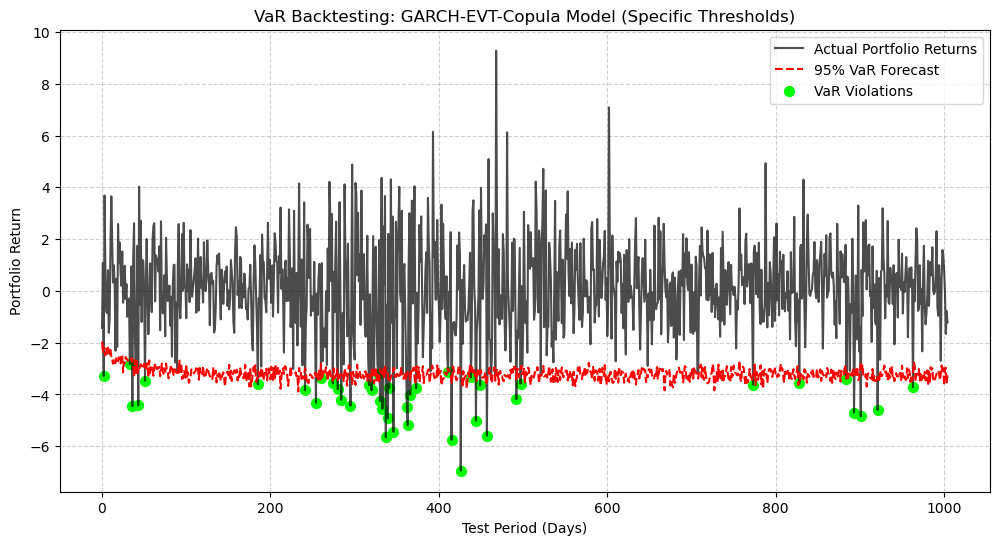

In [52]:
alpha = 0.05  # 99% VaR
# alpha = 0.05 # 95% VaR
n_sim = 1000
portfolio_weights = np.array([0.25, 0.25, 0.25, 0.25])

asset_names = list(gjr_garch_results.keys())
test_period_len = len(test_returns['AAPL'])
var_forecasts = np.zeros(test_period_len)
actual_portfolio_returns = pd.DataFrame(test_returns).dot(portfolio_weights)

print(f"\n백테스팅 시작... (테스트 기간: {test_period_len}일, 신뢰수준: {1-alpha:.2f})")

for t in range(test_period_len):
    # 1. 코풀라 샘플링
    u_sim_t = sample_vinecop(M, P, C, n_sim)
    z_sim_t = inverse_transform_uniform_to_residuals(u_sim_t, std_residuals_dict)
    sim_returns_t = np.zeros((n_sim, len(asset_names)))
    for i, name in enumerate(asset_names):
        # 3-1. 해당 날짜(t)의 예측 변동성 추출 (스칼라 값)
        forecasted_sigma_t = gjr_garch_results[name]['forecasted_sigma'][t]
        
        # ================================================================= #
        # ### 여기가 핵심 수정 부분 ###
        # 3-2. z_sim_t 딕셔너리에서 현재 자산(name)의 잔차 배열(벡터)을 추출
        asset_residuals_t = z_sim_t[name]
        
        # 3-3. 스칼라 * 벡터 연산으로 시뮬레이션 수익률 계산
        sim_returns_t[:, i] = forecasted_sigma_t * asset_residuals_t
        # ================================================================= #

    # 4. 포트폴리오 수익률 계산
    portfolio_sim_returns_t = sim_returns_t.dot(portfolio_weights)
    
    # 5. 해당 날짜(t)의 VaR 계산
    var_forecasts[t] = np.quantile(portfolio_sim_returns_t, alpha)

print("VaR 계산 완료.")

# --- 5. 백테스팅 결과 분석 및 Kupiec 테스트 ---
violations = actual_portfolio_returns < var_forecasts
num_violations = np.sum(violations)
violation_rate = num_violations / test_period_len

print("\n--- VaR 백테스팅 결과 ---")
print(f"VaR 신뢰수준 (1-alpha): {1-alpha:.2f}")
print(f"테스트 기간: {test_period_len}일")
print(f"예상 위반 횟수 (p*T): {alpha * test_period_len:.2f}")
print(f"실제 위반 횟수: {num_violations}")
print(f"위반 비율: {violation_rate:.4f} (기대 비율: {alpha})")

p = alpha
x = num_violations
T = test_period_len
if x == 0 or x == T:
    lr_pof = 0
else:
    log_L_unrestricted = x * np.log(x/T) + (T-x) * np.log(1 - x/T)
    log_L_restricted = x * np.log(p) + (T-x) * np.log(1-p)
    lr_pof = -2 * (log_L_restricted - log_L_unrestricted)

p_value_pof = 1 - chi2.cdf(lr_pof, df=1)

print("\n--- Kupiec의 POF 테스트 (Unconditional Coverage) ---")
print(f"LR 통계량: {lr_pof:.4f}")
print(f"P-value: {p_value_pof:.4f}")
if p_value_pof < 0.05:
    print("결과: 귀무가설 기각 (5% 유의수준). 모델의 위반 비율이 유의미하게 다릅니다.")
else:
    print("결과: 귀무가설 채택 (5% 유의수준). 모델이 적절한 위반 횟수를 보입니다.")
def christoffersen_independence_test(violations):
    """
    Christoffersen (1998) Independence Test
    H0: 위반이 독립적으로 발생
    """
    # 전이 행렬 계산
    n_00 = n_01 = n_10 = n_11 = 0
    
    for i in range(1, len(violations)):
        if not violations[i-1] and not violations[i]:
            n_00 += 1
        elif not violations[i-1] and violations[i]:
            n_01 += 1
        elif violations[i-1] and not violations[i]:
            n_10 += 1
        else:  # violations[i-1] and violations[i]
            n_11 += 1
    
    # 전이 확률 계산
    pi_01 = n_01 / (n_00 + n_01) if (n_00 + n_01) > 0 else 0
    pi_11 = n_11 / (n_10 + n_11) if (n_10 + n_11) > 0 else 0
    pi = (n_01 + n_11) / (n_00 + n_01 + n_10 + n_11)
    
    # 로그우도비 계산
    if pi > 0 and pi < 1 and pi_01 > 0 and pi_11 > 0 and (1-pi_01) > 0 and (1-pi_11) > 0:
        log_L_unrestricted = (n_00 * np.log(1-pi_01) + n_01 * np.log(pi_01) + 
                             n_10 * np.log(1-pi_11) + n_11 * np.log(pi_11))
        log_L_restricted = ((n_00 + n_10) * np.log(1-pi) + 
                           (n_01 + n_11) * np.log(pi))
        lr_ind = -2 * (log_L_restricted - log_L_unrestricted)
    else:
        lr_ind = 0
    
    # p-value 계산
    p_value_ind = 1 - chi2.cdf(lr_ind, df=1)
    
    return lr_ind, p_value_ind, pi_01, pi_11, pi

# Independence 테스트 실행
lr_ind, p_value_ind, pi_01, pi_11, pi = christoffersen_independence_test(violations)

print("\n=== Christoffersen의 Independence 테스트 ===")
print(f"전이 확률:")
print(f"  π₀₁ (비위반→위반): {pi_01:.4f}")
print(f"  π₁₁ (위반→위반): {pi_11:.4f}")
print(f"  π (무조건부 위반 확률): {pi:.4f}")
print(f"\nLR 통계량: {lr_ind:.4f}")
print(f"P-value: {p_value_ind:.4f}")
print(f"유의수준 5%에서의 기각역: χ²(1) = 3.841")

if p_value_ind < 0.05:
    print("결론: 귀무가설 기각 (5% 유의수준)")
    print("      → 위반이 독립적이지 않습니다 (클러스터링 존재).")
else:
    print("결론: 귀무가설 채택 (5% 유의수준)")
    print("      → 위반이 독립적으로 발생합니다.")
# --- 6. 시각화 ---
plt.figure(figsize=(12, 6))
plt.plot(actual_portfolio_returns.values, label='Actual Portfolio Returns', color='black', alpha=0.7)
plt.plot(var_forecasts, label=f'{(1-alpha)*100:.0f}% VaR Forecast', color='red', linestyle='--')
plt.scatter(np.where(violations)[0], actual_portfolio_returns[violations], color='lime', marker='o', s=50, label='VaR Violations')
plt.title('VaR Backtesting: GARCH-EVT-Copula Model (Specific Thresholds)')
plt.xlabel('Test Period (Days)')
plt.ylabel('Portfolio Return')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


백테스팅 시작... (테스트 기간: 1005일, 신뢰수준: 0.99)
VaR 계산 완료.

--- VaR 백테스팅 결과 ---
VaR 신뢰수준 (1-alpha): 0.99
테스트 기간: 1005일
예상 위반 횟수 (p*T): 10.05
실제 위반 횟수: 3
위반 비율: 0.0030 (기대 비율: 0.01)

--- Kupiec의 POF 테스트 (Unconditional Coverage) ---
LR 통계량: 6.8961
P-value: 0.0086
결과: 귀무가설 기각 (5% 유의수준). 모델의 위반 비율이 유의미하게 다릅니다.

=== Christoffersen의 Independence 테스트 ===
전이 확률:
  π₀₁ (비위반→위반): 0.0030
  π₁₁ (위반→위반): 0.0000
  π (무조건부 위반 확률): 0.0030

LR 통계량: 0.0000
P-value: 1.0000
유의수준 5%에서의 기각역: χ²(1) = 3.841
결론: 귀무가설 채택 (5% 유의수준)
      → 위반이 독립적으로 발생합니다.


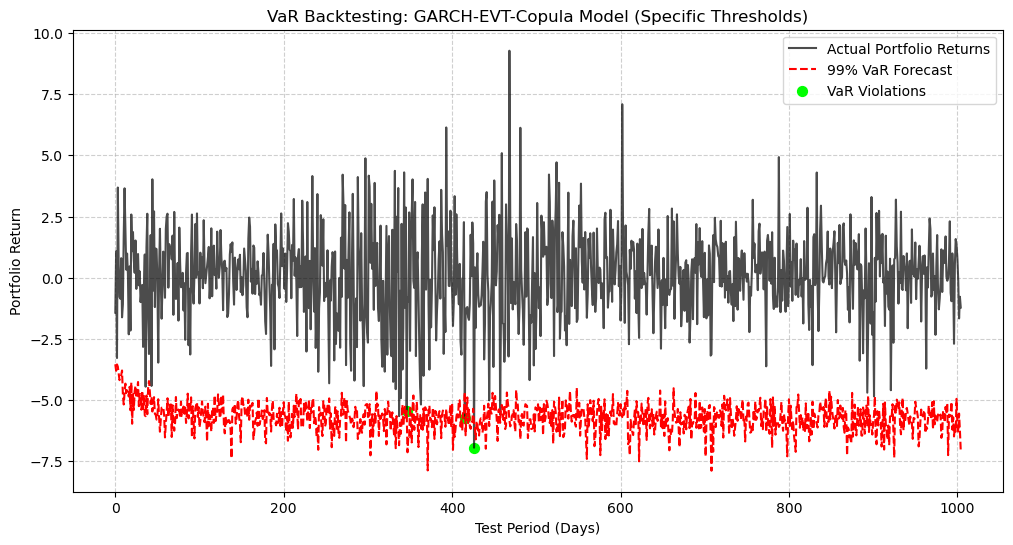

In [53]:
alpha = 0.01  # 99% VaR
# alpha = 0.05 # 95% VaR
n_sim = 1000
portfolio_weights = np.array([0.25, 0.25, 0.25, 0.25])

asset_names = list(gjr_garch_results.keys())
var_forecasts = np.zeros(test_period_len)
actual_portfolio_returns = pd.DataFrame(test_returns).dot(portfolio_weights)

print(f"\n백테스팅 시작... (테스트 기간: {test_period_len}일, 신뢰수준: {1-alpha:.2f})")

for t in range(test_period_len):
    # 1. 코풀라 샘플링
    u_sim_t = sample_vinecop(M, P, C, n_sim)
    
    # 2. 균등 분포 -> 표준화 잔차 딕셔너리로 변환
    # 이 함수는 {'AAPL': array, ...} 형태의 딕셔너리를 반환합니다.
    z_sim_t = inverse_transform_uniform_to_residuals(u_sim_t, std_residuals_dict)
    
    # 3. 시뮬레이션된 자산 수익률 계산
    sim_returns_t = np.zeros((n_sim, len(asset_names)))
    for i, name in enumerate(asset_names):
        # 3-1. 해당 날짜(t)의 예측 변동성 추출 (스칼라 값)
        forecasted_sigma_t = gjr_garch_results[name]['forecasted_sigma'][t]
        
        # ================================================================= #
        # ### 여기가 핵심 수정 부분 ###
        # 3-2. z_sim_t 딕셔너리에서 현재 자산(name)의 잔차 배열(벡터)을 추출
        asset_residuals_t = z_sim_t[name]
        
        # 3-3. 스칼라 * 벡터 연산으로 시뮬레이션 수익률 계산
        sim_returns_t[:, i] = forecasted_sigma_t * asset_residuals_t
        # ================================================================= #

    # 4. 포트폴리오 수익률 계산
    portfolio_sim_returns_t = sim_returns_t.dot(portfolio_weights)
    
    # 5. 해당 날짜(t)의 VaR 계산
    var_forecasts[t] = np.quantile(portfolio_sim_returns_t, alpha)

print("VaR 계산 완료.")

# --- 5. 백테스팅 결과 분석 및 Kupiec 테스트 ---
violations = actual_portfolio_returns < var_forecasts
num_violations = np.sum(violations)
violation_rate = num_violations / test_period_len

print("\n--- VaR 백테스팅 결과 ---")
print(f"VaR 신뢰수준 (1-alpha): {1-alpha:.2f}")
print(f"테스트 기간: {test_period_len}일")
print(f"예상 위반 횟수 (p*T): {alpha * test_period_len:.2f}")
print(f"실제 위반 횟수: {num_violations}")
print(f"위반 비율: {violation_rate:.4f} (기대 비율: {alpha})")

p = alpha
x = num_violations
T = test_period_len
if x == 0 or x == T:
    lr_pof = 0
else:
    log_L_unrestricted = x * np.log(x/T) + (T-x) * np.log(1 - x/T)
    log_L_restricted = x * np.log(p) + (T-x) * np.log(1-p)
    lr_pof = -2 * (log_L_restricted - log_L_unrestricted)

p_value_pof = 1 - chi2.cdf(lr_pof, df=1)

print("\n--- Kupiec의 POF 테스트 (Unconditional Coverage) ---")
print(f"LR 통계량: {lr_pof:.4f}")
print(f"P-value: {p_value_pof:.4f}")
if p_value_pof < 0.05:
    print("결과: 귀무가설 기각 (5% 유의수준). 모델의 위반 비율이 유의미하게 다릅니다.")
else:
    print("결과: 귀무가설 채택 (5% 유의수준). 모델이 적절한 위반 횟수를 보입니다.")
def christoffersen_independence_test(violations):
    """
    Christoffersen (1998) Independence Test
    H0: 위반이 독립적으로 발생
    """
    # 전이 행렬 계산
    n_00 = n_01 = n_10 = n_11 = 0
    
    for i in range(1, len(violations)):
        if not violations[i-1] and not violations[i]:
            n_00 += 1
        elif not violations[i-1] and violations[i]:
            n_01 += 1
        elif violations[i-1] and not violations[i]:
            n_10 += 1
        else:  # violations[i-1] and violations[i]
            n_11 += 1
    
    # 전이 확률 계산
    pi_01 = n_01 / (n_00 + n_01) if (n_00 + n_01) > 0 else 0
    pi_11 = n_11 / (n_10 + n_11) if (n_10 + n_11) > 0 else 0
    pi = (n_01 + n_11) / (n_00 + n_01 + n_10 + n_11)
    
    # 로그우도비 계산
    if pi > 0 and pi < 1 and pi_01 > 0 and pi_11 > 0 and (1-pi_01) > 0 and (1-pi_11) > 0:
        log_L_unrestricted = (n_00 * np.log(1-pi_01) + n_01 * np.log(pi_01) + 
                             n_10 * np.log(1-pi_11) + n_11 * np.log(pi_11))
        log_L_restricted = ((n_00 + n_10) * np.log(1-pi) + 
                           (n_01 + n_11) * np.log(pi))
        lr_ind = -2 * (log_L_restricted - log_L_unrestricted)
    else:
        lr_ind = 0
    
    # p-value 계산
    p_value_ind = 1 - chi2.cdf(lr_ind, df=1)
    
    return lr_ind, p_value_ind, pi_01, pi_11, pi

# Independence 테스트 실행
lr_ind, p_value_ind, pi_01, pi_11, pi = christoffersen_independence_test(violations)

print("\n=== Christoffersen의 Independence 테스트 ===")
print(f"전이 확률:")
print(f"  π₀₁ (비위반→위반): {pi_01:.4f}")
print(f"  π₁₁ (위반→위반): {pi_11:.4f}")
print(f"  π (무조건부 위반 확률): {pi:.4f}")
print(f"\nLR 통계량: {lr_ind:.4f}")
print(f"P-value: {p_value_ind:.4f}")
print(f"유의수준 5%에서의 기각역: χ²(1) = 3.841")

if p_value_ind < 0.05:
    print("결론: 귀무가설 기각 (5% 유의수준)")
    print("      → 위반이 독립적이지 않습니다 (클러스터링 존재).")
else:
    print("결론: 귀무가설 채택 (5% 유의수준)")
    print("      → 위반이 독립적으로 발생합니다.")
# --- 6. 시각화 ---
plt.figure(figsize=(12, 6))
plt.plot(actual_portfolio_returns.values, label='Actual Portfolio Returns', color='black', alpha=0.7)
plt.plot(var_forecasts, label=f'{(1-alpha)*100:.0f}% VaR Forecast', color='red', linestyle='--')
plt.scatter(np.where(violations)[0], actual_portfolio_returns[violations], color='lime', marker='o', s=50, label='VaR Violations')
plt.title('VaR Backtesting: GARCH-EVT-Copula Model (Specific Thresholds)')
plt.xlabel('Test Period (Days)')
plt.ylabel('Portfolio Return')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


백테스팅 시작... (테스트 기간: 1005일, 신뢰수준: 0.90)
VaR 계산 완료.

--- VaR 백테스팅 결과 ---
VaR 신뢰수준 (1-alpha): 0.90
테스트 기간: 1005일
예상 위반 횟수 (p*T): 100.50
실제 위반 횟수: 94
위반 비율: 0.0935 (기대 비율: 0.1)

--- Kupiec의 POF 테스트 (Unconditional Coverage) ---
LR 통계량: 0.4764
P-value: 0.4901
결과: 귀무가설 채택 (5% 유의수준). 모델이 적절한 위반 횟수를 보입니다.

=== Christoffersen의 Independence 테스트 ===
전이 확률:
  π₀₁ (비위반→위반): 0.0923
  π₁₁ (위반→위반): 0.0957
  π (무조건부 위반 확률): 0.0926

LR 통계량: 0.0119
P-value: 0.9132
유의수준 5%에서의 기각역: χ²(1) = 3.841
결론: 귀무가설 채택 (5% 유의수준)
      → 위반이 독립적으로 발생합니다.


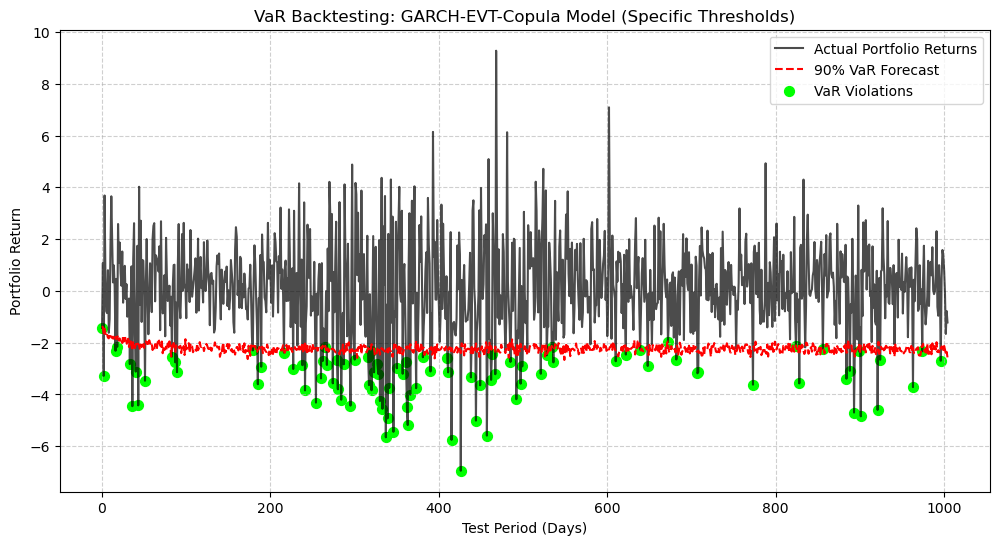

In [54]:
alpha = 0.10  # 99% VaR
# alpha = 0.05 # 95% VaR
n_sim = 1000
portfolio_weights = np.array([0.25, 0.25, 0.25, 0.25])
# (가정) gjr_garch_results, test_returns 등이 모두 준비된 상태

asset_names = list(gjr_garch_results.keys())
var_forecasts = np.zeros(test_period_len)
actual_portfolio_returns = pd.DataFrame(test_returns).dot(portfolio_weights)

print(f"\n백테스팅 시작... (테스트 기간: {test_period_len}일, 신뢰수준: {1-alpha:.2f})")

for t in range(test_period_len):
    # 1. 코풀라 샘플링
    u_sim_t = sample_vinecop(M, P, C, n_sim)
    
    # 2. 균등 분포 -> 표준화 잔차 딕셔너리로 변환
    # 이 함수는 {'AAPL': array, ...} 형태의 딕셔너리를 반환합니다.
    z_sim_t = inverse_transform_uniform_to_residuals(u_sim_t, std_residuals_dict)
    
    # 3. 시뮬레이션된 자산 수익률 계산
    sim_returns_t = np.zeros((n_sim, len(asset_names)))
    for i, name in enumerate(asset_names):
        # 3-1. 해당 날짜(t)의 예측 변동성 추출 (스칼라 값)
        forecasted_sigma_t = gjr_garch_results[name]['forecasted_sigma'][t]
        
        # ================================================================= #
        # ### 여기가 핵심 수정 부분 ###
        # 3-2. z_sim_t 딕셔너리에서 현재 자산(name)의 잔차 배열(벡터)을 추출
        asset_residuals_t = z_sim_t[name]
        
        # 3-3. 스칼라 * 벡터 연산으로 시뮬레이션 수익률 계산
        sim_returns_t[:, i] = forecasted_sigma_t * asset_residuals_t
        # ================================================================= #

    # 4. 포트폴리오 수익률 계산
    portfolio_sim_returns_t = sim_returns_t.dot(portfolio_weights)
    
    # 5. 해당 날짜(t)의 VaR 계산
    var_forecasts[t] = np.quantile(portfolio_sim_returns_t, alpha)

print("VaR 계산 완료.")

# --- 5. 백테스팅 결과 분석 및 Kupiec 테스트 ---
violations = actual_portfolio_returns < var_forecasts
num_violations = np.sum(violations)
violation_rate = num_violations / test_period_len

print("\n--- VaR 백테스팅 결과 ---")
print(f"VaR 신뢰수준 (1-alpha): {1-alpha:.2f}")
print(f"테스트 기간: {test_period_len}일")
print(f"예상 위반 횟수 (p*T): {alpha * test_period_len:.2f}")
print(f"실제 위반 횟수: {num_violations}")
print(f"위반 비율: {violation_rate:.4f} (기대 비율: {alpha})")

p = alpha
x = num_violations
T = test_period_len
if x == 0 or x == T:
    lr_pof = 0
else:
    log_L_unrestricted = x * np.log(x/T) + (T-x) * np.log(1 - x/T)
    log_L_restricted = x * np.log(p) + (T-x) * np.log(1-p)
    lr_pof = -2 * (log_L_restricted - log_L_unrestricted)

p_value_pof = 1 - chi2.cdf(lr_pof, df=1)

print("\n--- Kupiec의 POF 테스트 (Unconditional Coverage) ---")
print(f"LR 통계량: {lr_pof:.4f}")
print(f"P-value: {p_value_pof:.4f}")
if p_value_pof < 0.05:
    print("결과: 귀무가설 기각 (5% 유의수준). 모델의 위반 비율이 유의미하게 다릅니다.")
else:
    print("결과: 귀무가설 채택 (5% 유의수준). 모델이 적절한 위반 횟수를 보입니다.")
def christoffersen_independence_test(violations):
    """
    Christoffersen (1998) Independence Test
    H0: 위반이 독립적으로 발생
    """
    # 전이 행렬 계산
    n_00 = n_01 = n_10 = n_11 = 0
    
    for i in range(1, len(violations)):
        if not violations[i-1] and not violations[i]:
            n_00 += 1
        elif not violations[i-1] and violations[i]:
            n_01 += 1
        elif violations[i-1] and not violations[i]:
            n_10 += 1
        else:  # violations[i-1] and violations[i]
            n_11 += 1
    
    # 전이 확률 계산
    pi_01 = n_01 / (n_00 + n_01) if (n_00 + n_01) > 0 else 0
    pi_11 = n_11 / (n_10 + n_11) if (n_10 + n_11) > 0 else 0
    pi = (n_01 + n_11) / (n_00 + n_01 + n_10 + n_11)
    
    # 로그우도비 계산
    if pi > 0 and pi < 1 and pi_01 > 0 and pi_11 > 0 and (1-pi_01) > 0 and (1-pi_11) > 0:
        log_L_unrestricted = (n_00 * np.log(1-pi_01) + n_01 * np.log(pi_01) + 
                             n_10 * np.log(1-pi_11) + n_11 * np.log(pi_11))
        log_L_restricted = ((n_00 + n_10) * np.log(1-pi) + 
                           (n_01 + n_11) * np.log(pi))
        lr_ind = -2 * (log_L_restricted - log_L_unrestricted)
    else:
        lr_ind = 0
    
    # p-value 계산
    p_value_ind = 1 - chi2.cdf(lr_ind, df=1)
    
    return lr_ind, p_value_ind, pi_01, pi_11, pi

# Independence 테스트 실행
lr_ind, p_value_ind, pi_01, pi_11, pi = christoffersen_independence_test(violations)

print("\n=== Christoffersen의 Independence 테스트 ===")
print(f"전이 확률:")
print(f"  π₀₁ (비위반→위반): {pi_01:.4f}")
print(f"  π₁₁ (위반→위반): {pi_11:.4f}")
print(f"  π (무조건부 위반 확률): {pi:.4f}")
print(f"\nLR 통계량: {lr_ind:.4f}")
print(f"P-value: {p_value_ind:.4f}")
print(f"유의수준 5%에서의 기각역: χ²(1) = 3.841")

if p_value_ind < 0.05:
    print("결론: 귀무가설 기각 (5% 유의수준)")
    print("      → 위반이 독립적이지 않습니다 (클러스터링 존재).")
else:
    print("결론: 귀무가설 채택 (5% 유의수준)")
    print("      → 위반이 독립적으로 발생합니다.")
# --- 6. 시각화 ---
plt.figure(figsize=(12, 6))
plt.plot(actual_portfolio_returns.values, label='Actual Portfolio Returns', color='black', alpha=0.7)
plt.plot(var_forecasts, label=f'{(1-alpha)*100:.0f}% VaR Forecast', color='red', linestyle='--')
plt.scatter(np.where(violations)[0], actual_portfolio_returns[violations], color='lime', marker='o', s=50, label='VaR Violations')
plt.title('VaR Backtesting: GARCH-EVT-Copula Model (Specific Thresholds)')
plt.xlabel('Test Period (Days)')
plt.ylabel('Portfolio Return')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

포트폴리오 수익률 계산 중...
훈련 데이터 기간: 2015-01-05 ~ 2020-12-31 (1511일)
테스트 데이터 기간: 2021-01-04 ~ 2024-12-31 (1005일)

GARCH-t 모델 피팅 중...
모델 피팅 완료.

주요 파라미터:
  Mean (μ): 0.173054
  Omega (ω): 0.123162
  Alpha (α): 0.025361
  Gamma (γ): 0.193105
  Beta (β): 0.832709
  Nu (ν): 4.29

Rolling window 예측 수행 중...
  진행률: 10.0%
  진행률: 19.9%
  진행률: 29.9%
  진행률: 39.8%
  진행률: 49.8%
  진행률: 59.7%
  진행률: 69.7%
  진행률: 79.6%
  진행률: 89.6%
  진행률: 99.5%

--- VaR 백테스팅 결과 (GARCH-t with Rolling Window) ---
테스트 기간: 1005일

95% VaR:
  예상 위반 횟수: 50.25
  실제 위반 횟수: 37
  위반 비율: 0.0368 (기대: 0.05)

99% VaR:
  예상 위반 횟수: 10.05
  실제 위반 횟수: 2
  위반 비율: 0.0020 (기대: 0.01)

--- Kupiec POF Test (Unconditional Coverage) ---
95% VaR: LR = 4.0322, p-value = 0.0446 (Reject)
99% VaR: LR = 9.7073, p-value = 0.0018 (Reject)

--- Christoffersen Independence Test ---
95% VaR: LR = 0.2826, p-value = 0.5950 (Accept)
99% VaR: LR = 0.0000, p-value = 1.0000 (Accept)


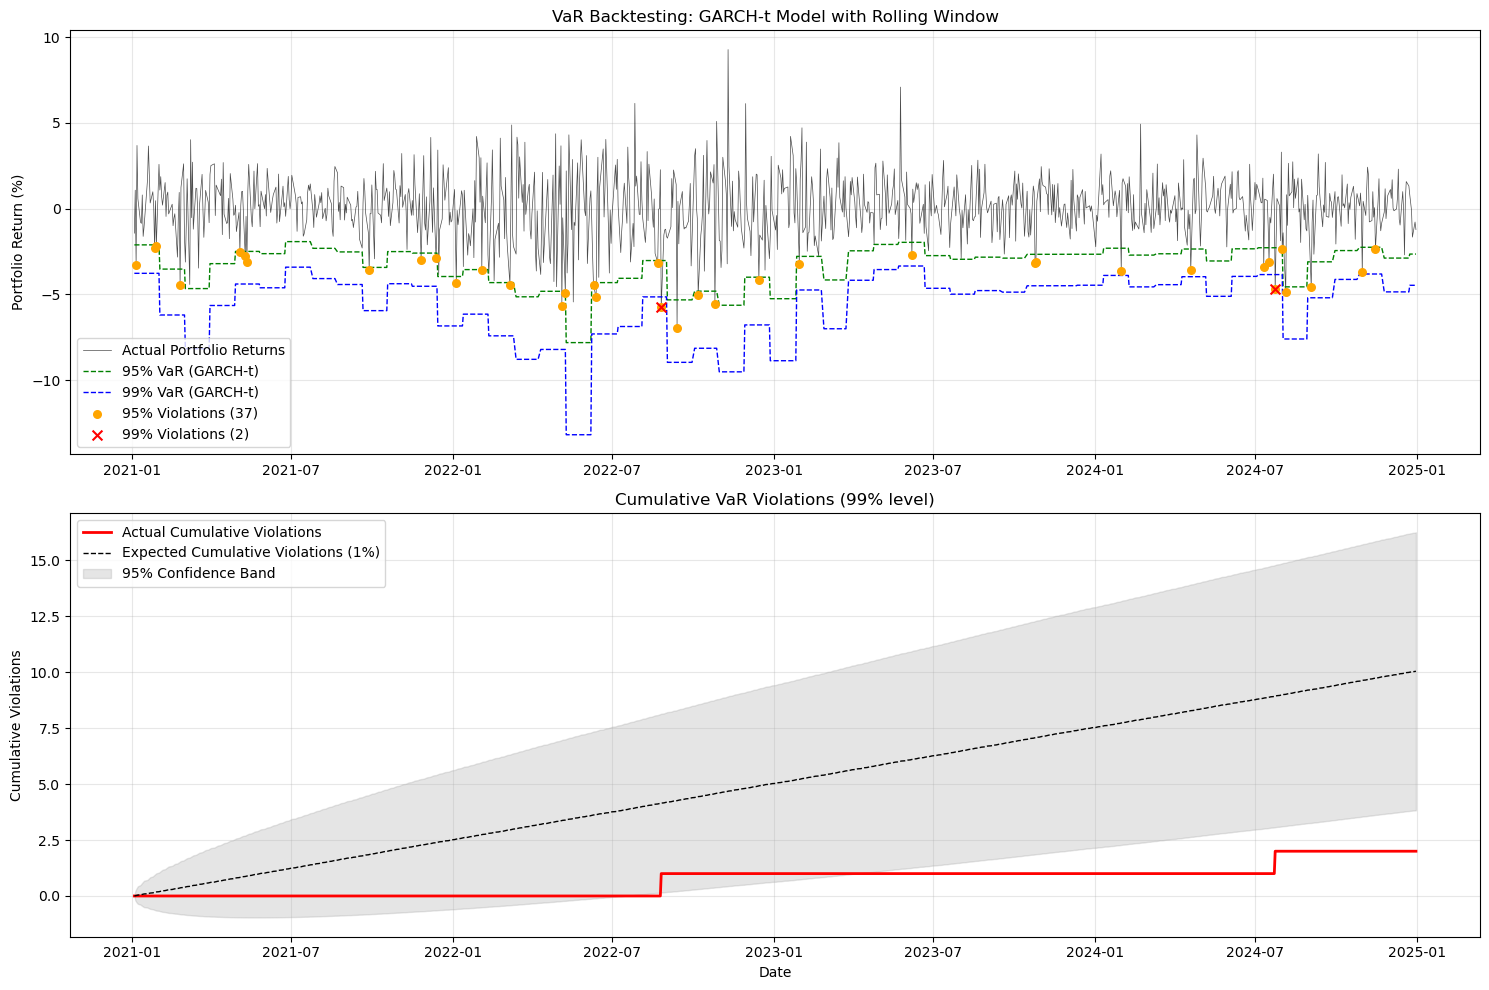

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from scipy.stats import norm, chi2, t
import warnings
warnings.filterwarnings('ignore')

# --- 1. 데이터 준비 (기존 코드 유지) ---
train_returns = all_returns

# --- 2. 포트폴리오 수익률 계산 ---
print("포트폴리오 수익률 계산 중...")
num_assets = len(asset_files)
portfolio_weights = np.array([1/num_assets] * num_assets)

df_train_returns = pd.DataFrame(train_returns).dropna()
df_test_returns = pd.DataFrame(test_returns).dropna()

portfolio_train_returns = df_train_returns.dot(portfolio_weights)
portfolio_test_returns = df_test_returns.dot(portfolio_weights)

print(f"훈련 데이터 기간: {portfolio_train_returns.index.min().date()} ~ {portfolio_train_returns.index.max().date()} ({len(portfolio_train_returns)}일)")
print(f"테스트 데이터 기간: {portfolio_test_returns.index.min().date()} ~ {portfolio_test_returns.index.max().date()} ({len(portfolio_test_returns)}일)")

# --- 3. 개선된 GARCH-t 모델 피팅 ---
print("\nGARCH-t 모델 피팅 중...")

# 개선점 1: GJR-GARCH 사용 (비대칭성 고려)
garch_model = arch_model(portfolio_train_returns, vol='GARCH', p=1, o=1, q=1, dist='t')
res = garch_model.fit(disp='off', options={'maxiter': 1000})

print("모델 피팅 완료.")
print("\n주요 파라미터:")
print(f"  Mean (μ): {res.params['mu']:.6f}")
print(f"  Omega (ω): {res.params['omega']:.6f}")
print(f"  Alpha (α): {res.params['alpha[1]']:.6f}")
print(f"  Gamma (γ): {res.params.get('gamma[1]', 0):.6f}")  # GJR parameter
print(f"  Beta (β): {res.params['beta[1]']:.6f}")
print(f"  Nu (ν): {res.params['nu']:.2f}")

# 개선점 2: Out-of-sample 예측을 rolling window로 수행
print("\nRolling window 예측 수행 중...")

# 빈 리스트 초기화
var_95_list = []
var_99_list = []
dates_list = []

# Rolling window 예측
window_size = 252  # 1년 window
for i in range(len(portfolio_test_returns)):
    # 현재까지의 모든 훈련 데이터 + 테스트 데이터 사용
    current_data = pd.concat([portfolio_train_returns, portfolio_test_returns.iloc[:i]])
    
    # 모델 재추정 (매 20일마다)
    if i % 20 == 0:
        temp_model = arch_model(current_data, vol='GARCH', p=1, o=1, q=1, dist='t')
        temp_res = temp_model.fit(disp='off', last_obs=i+len(portfolio_train_returns)-1)
        current_params = temp_res.params
    
    # 1일 ahead 예측
    forecast = temp_res.forecast(horizon=1)
    sigma_forecast = np.sqrt(forecast.variance.values[-1, 0])
    
    # t-분포 사용하여 VaR 계산
    nu = current_params['nu']
    mu = current_params['mu']
    
    # 95% VaR
    t_quantile_95 = t.ppf(0.05, df=nu)
    var_95 = mu + sigma_forecast * t_quantile_95
    var_95_list.append(var_95)
    
    # 99% VaR
    t_quantile_99 = t.ppf(0.01, df=nu)
    var_99 = mu + sigma_forecast * t_quantile_99
    var_99_list.append(var_99)
    
    dates_list.append(portfolio_test_returns.index[i])
    
    if (i+1) % 100 == 0:
        print(f"  진행률: {(i+1)/len(portfolio_test_returns)*100:.1f}%")

var_95_forecasts = np.array(var_95_list)
var_99_forecasts = np.array(var_99_list)

# --- 4. 개선된 백테스팅 ---
actual_portfolio_returns = portfolio_test_returns.values

# 95% VaR 백테스팅
violations_95 = actual_portfolio_returns < var_95_forecasts
num_violations_95 = np.sum(violations_95)
violation_rate_95 = num_violations_95 / len(portfolio_test_returns)

# 99% VaR 백테스팅
violations_99 = actual_portfolio_returns < var_99_forecasts
num_violations_99 = np.sum(violations_99)
violation_rate_99 = num_violations_99 / len(portfolio_test_returns)

print("\n--- VaR 백테스팅 결과 (GARCH-t with Rolling Window) ---")
print(f"테스트 기간: {len(portfolio_test_returns)}일")
print(f"\n95% VaR:")
print(f"  예상 위반 횟수: {0.05 * len(portfolio_test_returns):.2f}")
print(f"  실제 위반 횟수: {num_violations_95}")
print(f"  위반 비율: {violation_rate_95:.4f} (기대: 0.05)")

print(f"\n99% VaR:")
print(f"  예상 위반 횟수: {0.01 * len(portfolio_test_returns):.2f}")
print(f"  실제 위반 횟수: {num_violations_99}")
print(f"  위반 비율: {violation_rate_99:.4f} (기대: 0.01)")

# --- 5. 개선된 통계 테스트 ---
def kupiec_test(violations, T, alpha):
    """Kupiec POF test"""
    x = np.sum(violations)
    p = alpha
    
    if x == 0:
        x = 0.5  # 연속성 보정
    
    lr_pof = -2 * (x * np.log(p) + (T-x) * np.log(1-p) - 
                   x * np.log(x/T) - (T-x) * np.log(1-x/T))
    
    p_value = 1 - chi2.cdf(lr_pof, df=1)
    return lr_pof, p_value

def christoffersen_test(violations):
    """Christoffersen Independence Test"""
    # Transition matrix
    n00 = np.sum((violations[:-1] == 0) & (violations[1:] == 0))
    n01 = np.sum((violations[:-1] == 0) & (violations[1:] == 1))
    n10 = np.sum((violations[:-1] == 1) & (violations[1:] == 0))
    n11 = np.sum((violations[:-1] == 1) & (violations[1:] == 1))
    
    # Probabilities
    p01 = n01 / (n00 + n01) if (n00 + n01) > 0 else 0
    p11 = n11 / (n10 + n11) if (n10 + n11) > 0 else 0
    p = (n01 + n11) / (n00 + n01 + n10 + n11)
    
    # LR statistic
    if p01 > 0 and p11 > 0 and p > 0:
        lr_ind = -2 * ((n00 + n10) * np.log(1-p) + (n01 + n11) * np.log(p) -
                       n00 * np.log(1-p01) - n01 * np.log(p01) -
                       n10 * np.log(1-p11) - n11 * np.log(p11))
    else:
        lr_ind = 0
    
    p_value = 1 - chi2.cdf(lr_ind, df=1)
    return lr_ind, p_value

# 95% VaR 테스트
lr_pof_95, p_value_pof_95 = kupiec_test(violations_95, len(portfolio_test_returns), 0.05)
lr_ind_95, p_value_ind_95 = christoffersen_test(violations_95)

# 99% VaR 테스트
lr_pof_99, p_value_pof_99 = kupiec_test(violations_99, len(portfolio_test_returns), 0.01)
lr_ind_99, p_value_ind_99 = christoffersen_test(violations_99)

print("\n--- Kupiec POF Test (Unconditional Coverage) ---")
print(f"95% VaR: LR = {lr_pof_95:.4f}, p-value = {p_value_pof_95:.4f} {'(Reject)' if p_value_pof_95 < 0.05 else '(Accept)'}")
print(f"99% VaR: LR = {lr_pof_99:.4f}, p-value = {p_value_pof_99:.4f} {'(Reject)' if p_value_pof_99 < 0.05 else '(Accept)'}")

print("\n--- Christoffersen Independence Test ---")
print(f"95% VaR: LR = {lr_ind_95:.4f}, p-value = {p_value_ind_95:.4f} {'(Reject)' if p_value_ind_95 < 0.05 else '(Accept)'}")
print(f"99% VaR: LR = {lr_ind_99:.4f}, p-value = {p_value_ind_99:.4f} {'(Reject)' if p_value_ind_99 < 0.05 else '(Accept)'}")

# --- 6. 개선된 시각화 ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# 상단: 전체 기간
ax1.plot(portfolio_test_returns.index, actual_portfolio_returns, 
         label='Actual Portfolio Returns', color='black', alpha=0.7, linewidth=0.5)
ax1.plot(portfolio_test_returns.index, var_95_forecasts, 
         label='95% VaR (GARCH-t)', color='green', linestyle='--', linewidth=1)
ax1.plot(portfolio_test_returns.index, var_99_forecasts, 
         label='99% VaR (GARCH-t)', color='blue', linestyle='--', linewidth=1)

# Violations 표시
ax1.scatter(portfolio_test_returns.index[violations_95], 
           actual_portfolio_returns[violations_95], 
           color='orange', marker='o', s=30, label=f'95% Violations ({num_violations_95})', zorder=5)
ax1.scatter(portfolio_test_returns.index[violations_99], 
           actual_portfolio_returns[violations_99], 
           color='red', marker='x', s=50, label=f'99% Violations ({num_violations_99})', zorder=5)

ax1.set_title('VaR Backtesting: GARCH-t Model with Rolling Window')
ax1.set_ylabel('Portfolio Return (%)')
ax1.legend(loc='lower left')
ax1.grid(True, alpha=0.3)

# 하단: Violation clustering 분석
violation_binary = violations_99.astype(int)
cumsum_violations = np.cumsum(violation_binary)
expected_violations = np.arange(len(violation_binary)) * 0.01

ax2.plot(portfolio_test_returns.index, cumsum_violations, 
         label='Actual Cumulative Violations', color='red', linewidth=2)
ax2.plot(portfolio_test_returns.index, expected_violations, 
         label='Expected Cumulative Violations (1%)', color='black', linestyle='--', linewidth=1)
ax2.fill_between(portfolio_test_returns.index, 
                 expected_violations - 1.96*np.sqrt(expected_violations),
                 expected_violations + 1.96*np.sqrt(expected_violations),
                 alpha=0.2, color='gray', label='95% Confidence Band')

ax2.set_title('Cumulative VaR Violations (99% level)')
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative Violations')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
